# CUDA HRP (60-Month Lookback)

## Hierarchical Risk Parity Portfolio Optimization
- Uses 60-month lookback window for covariance estimation
- GPU-accelerated via CUDA/CuPy
- RMT Denoising (Random Matrix Theory) for robust covariance estimation
- Monthly rebalancing with liquidity-filtered universe

In [1]:
# Cell 0: Install Required Packages (Run if not already installed)

# Note: ta (not ta-lib) is easier to install on Windows
# Using cupy-cuda12x for CUDA 12.x compatibility (RTX 5090 with CUDA 12.8)
# PyTorch 2.8 template compatibility
!pip install cupy-cuda12x scikit-learn scipy tqdm pandas numpy matplotlib xgboost ta joblib pyyaml pytest


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Dependencies

import os
import sys
import importlib
import pandas as pd

# Add utils/ to path
current_dir = os.getcwd()
utils_path = os.path.join(os.path.dirname(current_dir), 'utils')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

import hrp_setup
import hrp_data
import hrp_analytics
import hrp_logger 

# Force reload to ensure new functions are available
importlib.reload(hrp_setup)
importlib.reload(hrp_logger)

# Setup Environment (Imports, Cache, GPU, Seeds)
project_root, GPU_AVAILABLE, hrp_pipeline = hrp_setup.setup_environment(current_dir)

# Load Configuration
config = hrp_setup.load_config(project_root)

# Setup Logging
log_file_path = os.path.join(project_root, 'hrp_agent.log')
logger = hrp_logger.setup_logger(log_file=log_file_path)
logger.info("Starting HRP Pipeline (60-Month Window)")

# Configuration from Config File
if config:
    super_agent_dir = os.path.join(project_root, config['project']['output_dir'])
    window = config['data']['window']
    rebalance_freq = config['data']['rebalance_freq']
    min_stocks = config['data']['min_stocks']
    market_index = config['data']['market_index']
    logger.info(f"Loaded configuration: Window={window}, Rebalance={rebalance_freq}")
else:
    # Fallback if config fails
    logger.warning("Config load failed, using defaults")
    super_agent_dir = os.path.join(project_root, 'Super_Agent_Output')
    window = 60
    rebalance_freq = '1M'
    min_stocks = 20
    market_index = 'VWRETD'

os.makedirs(super_agent_dir, exist_ok=True)
logger.info(f"Output Directory: {super_agent_dir}")

c:\Users\lucas\AppData\Local\Programs\Python\Python313\Lib\site-packages\cupy\_environment.py:215: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


✓ SOTA Covariance (RMT Denoising) loaded successfully.
✓ SOTA Covariance (RMT Denoising) loaded successfully.
✓ CuPy version: 13.6.0
✓ CUDA version: 12090
✓ Random seeds set to 42
✓ Loaded configuration from c:\Users\lucas\OneDrive\Bureau\HRP\config.yaml
✓ Random seeds set to 42
2026-01-06 23:34:00,639 - HRP_Agent - INFO - Starting HRP Pipeline (60-Month Window)
2026-01-06 23:34:00,643 - HRP_Agent - INFO - Loaded configuration: Window=60, Rebalance=1M
2026-01-06 23:34:00,653 - HRP_Agent - INFO - Output Directory: c:\Users\lucas\OneDrive\Bureau\HRP\Super_Agent_Output


In [3]:
# Step 1: Load and Filter Data

# Locate Files
data_path, benchmark_path, prep_path, comp_path = hrp_setup.get_file_paths(project_root, hrp_data)

# Load Market Data
returns_all, dates, valid_rebal_dates, df_ml_universe, universe_flags = hrp_data.load_market_data(
    data_path, 
    benchmark_path,
    start_date_str='1960-01-01', 
    market_index=market_index, 
    windows=[window],  
    freq=rebalance_freq
)

# Load Risk Free Rate
rf_monthly_aligned = hrp_data.load_risk_free_rate(prep_path, dates, start_date_str='1960-01-01')

print(f"{'='*70}\n")

✓ Found data at: c:\Users\lucas\OneDrive\Bureau\HRP\DATA\CRSP\CRSP_selected_columns.csv
Loading stock data from c:\Users\lucas\OneDrive\Bureau\HRP\DATA\CRSP\CRSP_selected_columns.csv...
Loaded raw data: 5218898 rows, 10 columns
Unique PERMNOs (Raw): 38843
Filtering raw data to start from 1960-01-01...
Unique PERMNOs (After Date Filter): 38384
Filtering by SHRCD (10, 11) and EXCHCD (1, 2, 3)...
Unique PERMNOs (After SHRCD/EXCHCD Filter): 26293
Merging RET and DLRET columns...
Calculating universe flags...
✓ Found SIC mapping file: c:\Users\lucas\OneDrive\Bureau\HRP\DATA\CRSP\SIC_to_Fama_French_industry.csv
Mapping stocks to Fama-French 12 Industries...
Calculating Rolling 12-Month Median Liquidity...
Filtering Top 20% Liquidity per Industry/Date...
  - Applied FF12 Industry Filter (Top 20% Rolling Median Liquidity)
  - Market Cap: Top 80% (for ML Universe)
Unique PERMNOs (ML Universe - Top 80% Mkt Cap): 24160
Unique PERMNOs (HRP Universe - Liquidity & Price): 7088
Universe (Full): 35103

RMT DENOISING VISUALIZATION: 1993-03
Date: 1993-03, Universe: 1137, Before filter: 878 stocks, 61 months
  After filter: 878 stocks with 60+ months
  MP threshold: λ_max=22.981 (q=N/T=14.39), Signal: 3/60 non-zero eigenvalues


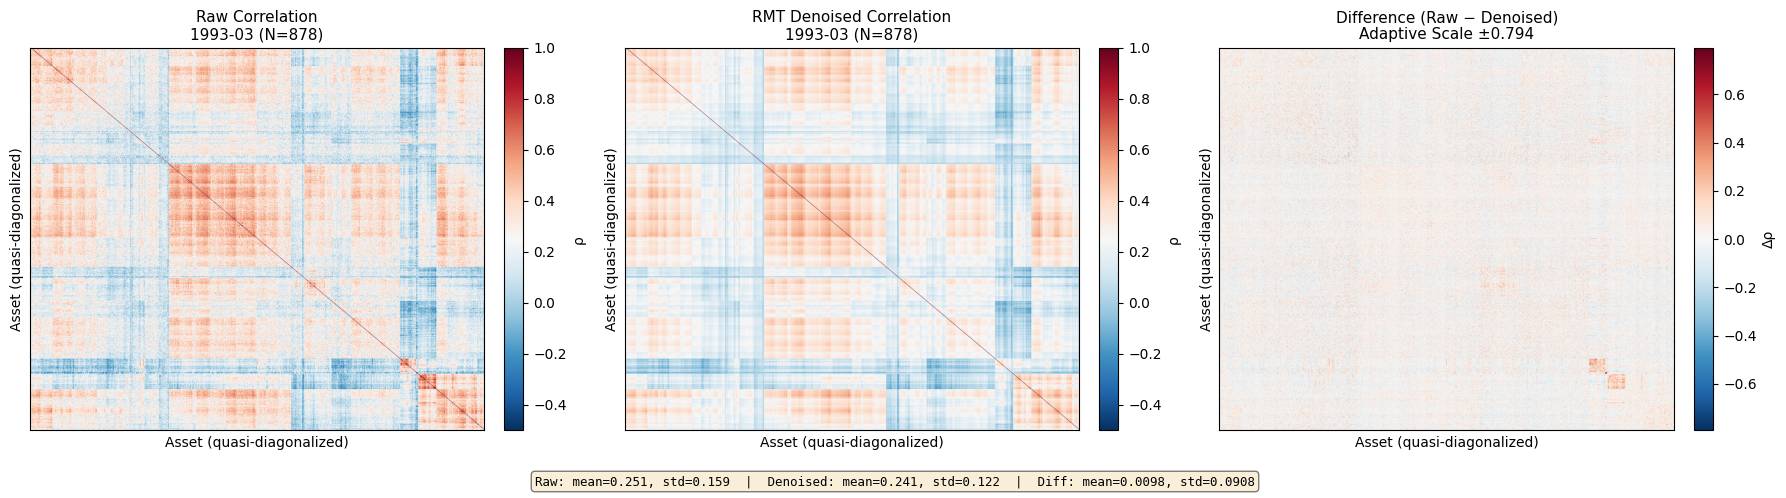

✓ Saved: c:\Users\lucas\OneDrive\Bureau\HRP\Super_Agent_Output\rmt_denoising_1993-03.png

RMT DENOISING VISUALIZATION: 2015-09
Date: 2015-09, Universe: 735, Before filter: 624 stocks, 61 months
  After filter: 624 stocks with 60+ months
  MP threshold: λ_max=17.626 (q=N/T=10.23), Signal: 3/60 non-zero eigenvalues


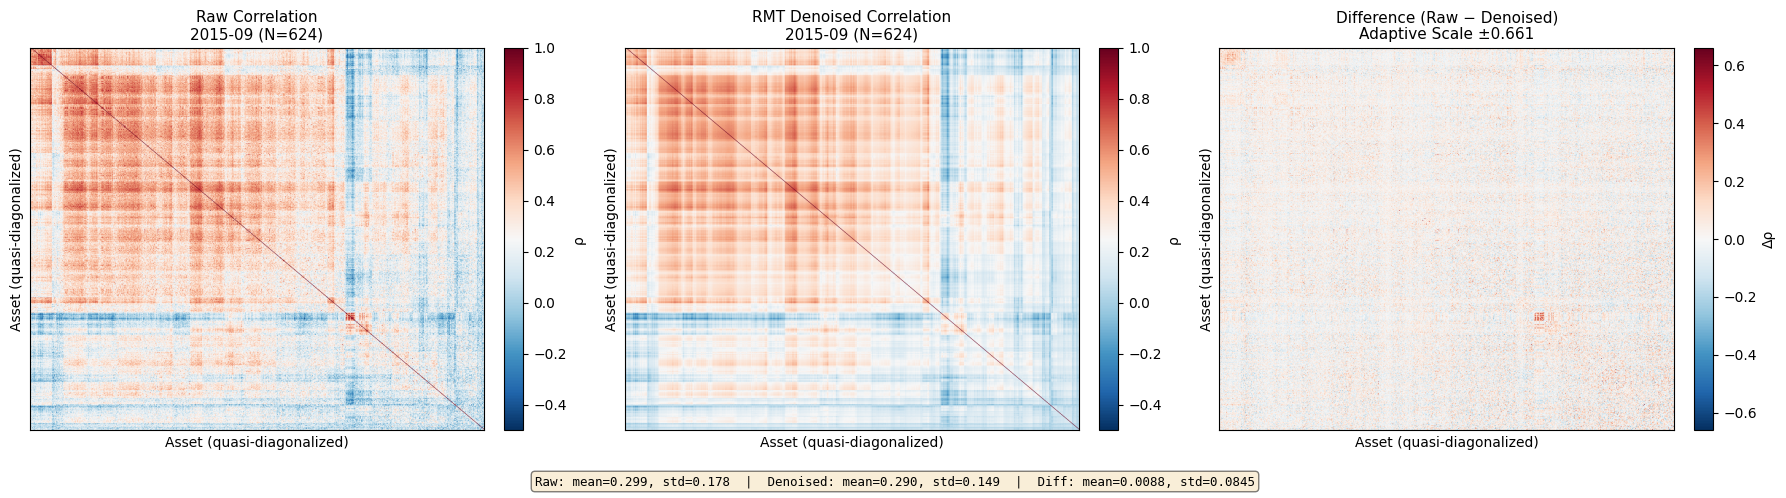

✓ Saved: c:\Users\lucas\OneDrive\Bureau\HRP\Super_Agent_Output\rmt_denoising_2015-09.png

✓ RMT denoising visualizations complete


In [6]:
# Step 1.5: RMT Denoising Visualization (Before vs After)

# Reload modules to pick up fixes
import cov_shrinkage
importlib.reload(cov_shrinkage)
importlib.reload(hrp_analytics)

# Plot for March 1993
print("="*70)
print("RMT DENOISING VISUALIZATION: 1993-03")
print("="*70)
corr_raw_1993, corr_denoised_1993 = hrp_analytics.plot_rmt_comparison(
    returns_all, universe_flags, 
    '1993-03-31', window,
    os.path.join(super_agent_dir, 'rmt_denoising_1993-03.png')
)

# Plot for September 2015
print("\n" + "="*70)
print("RMT DENOISING VISUALIZATION: 2015-09")
print("="*70)
corr_raw_2015, corr_denoised_2015 = hrp_analytics.plot_rmt_comparison(
    returns_all, universe_flags,
    '2015-09-30', window,
    os.path.join(super_agent_dir, 'rmt_denoising_2015-09.png')
)

print("\n✓ RMT denoising visualizations complete")

In [8]:
# Step 2: HRP Weights & Monthly Returns Computation

import hrp_functions
import hrp_pipeline

# Check config for recompute option (defaults to True if not specified)
recompute_weights = config.get('computation', {}).get('recompute_weights', True)

if recompute_weights:
    print("▶ Recomputing HRP weights from scratch...")
    strategy_returns = hrp_pipeline.run_hrp_computation(
        returns_all, 
        valid_rebal_dates, 
        window, 
        min_stocks, 
        super_agent_dir,
        universe_flags=universe_flags
    )
else:
    print("▶ Loading pre-computed HRP weights (recompute_weights: false)")
    # Load pre-computed CSV files
    weights_path = os.path.join(super_agent_dir, 'all_hrp_weights.csv')
    returns_path = os.path.join(super_agent_dir, 'hrp_strategy_returns.csv')
    
    if not os.path.exists(weights_path) or not os.path.exists(returns_path):
        raise FileNotFoundError(
            f"Pre-computed files not found. Set recompute_weights: true in config.yaml\n"
            f"  Expected: {weights_path}\n"
            f"  Expected: {returns_path}"
        )
    
    hrp_weights = pd.read_csv(weights_path, index_col=0, parse_dates=True)
    strategy_returns = pd.read_csv(returns_path, index_col=0, parse_dates=True).squeeze()
    
    print(f"  ✓ Loaded weights: {hrp_weights.shape[0]} months, {hrp_weights.shape[1]} stocks")
    print(f"  ✓ Loaded returns: {len(strategy_returns)} months ({strategy_returns.index.min():%Y-%m} to {strategy_returns.index.max():%Y-%m})")

▶ Recomputing HRP weights from scratch...
2026-01-06 00:28:18,030 - HRP_Agent - INFO - 
2026-01-06 00:28:18,032 - HRP_Agent - INFO - HRP COMPUTATION (Window: 60 months)
2026-01-06 00:28:18,034 - HRP_Agent - INFO - ======================================================================
2026-01-06 00:28:18,043 - HRP_Agent - INFO - Found checkpoint file. Loading previous progress...
2026-01-06 00:28:18,216 - HRP_Agent - INFO - Resuming from rebalance 61/720
2026-01-06 00:28:18,218 - HRP_Agent - INFO - Total rebalance dates: 720
2026-01-06 00:28:18,220 - HRP_Agent - INFO - Window: 60 months


Computing HRP:   9%|▉         | 65/720 [00:09<25:53,  2.37s/it]

2026-01-06 00:28:30,355 - HRP_Agent - WARNING -   [!] 1970-06-30: 1 missing returns treated as -100% loss. Stocks: ['37591']


Computing HRP:  10%|█         | 73/720 [00:29<26:43,  2.48s/it]

2026-01-06 00:28:49,791 - HRP_Agent - WARNING -   [!] 1971-02-26: 1 missing returns treated as -100% loss. Stocks: ['26067']


Computing HRP:  10%|█         | 74/720 [00:31<25:59,  2.41s/it]

2026-01-06 00:28:52,239 - HRP_Agent - WARNING -   [!] 1971-03-31: 1 missing returns treated as -100% loss. Stocks: ['40029']


Computing HRP:  13%|█▎        | 97/720 [01:30<26:49,  2.58s/it]

2026-01-06 00:29:51,008 - HRP_Agent - WARNING -   [!] 1973-02-28: 1 missing returns treated as -100% loss. Stocks: ['12837']


Computing HRP:  14%|█▍        | 99/720 [01:35<26:24,  2.55s/it]

2026-01-06 00:29:56,004 - HRP_Agent - WARNING -   [!] 1973-04-30: 1 missing returns treated as -100% loss. Stocks: ['32125']


Computing HRP:  14%|█▍        | 100/720 [01:37<25:55,  2.51s/it]

2026-01-06 00:29:58,603 - HRP_Agent - WARNING -   [!] 1973-05-31: 1 missing returns treated as -100% loss. Stocks: ['38893']


Computing HRP:  14%|█▍        | 101/720 [01:40<26:46,  2.60s/it]

2026-01-06 00:30:02,591 - HRP_Agent - WARNING -   [!] 1973-06-29: 1 missing returns treated as -100% loss. Stocks: ['46367']


Computing HRP:  14%|█▍        | 103/720 [01:47<29:38,  2.88s/it]

2026-01-06 00:30:08,055 - HRP_Agent - WARNING -   [!] 1973-08-31: 1 missing returns treated as -100% loss. Stocks: ['37268']


Computing HRP:  15%|█▌        | 108/720 [02:00<27:05,  2.66s/it]

2026-01-06 00:30:21,068 - HRP_Agent - WARNING -   [!] 1974-01-31: 1 missing returns treated as -100% loss. Stocks: ['41785']


Computing HRP:  16%|█▌        | 112/720 [02:10<27:00,  2.67s/it]

2026-01-06 00:30:32,067 - HRP_Agent - WARNING -   [!] 1974-05-31: 1 missing returns treated as -100% loss. Stocks: ['47829']


Computing HRP:  16%|█▌        | 116/720 [02:23<29:29,  2.93s/it]

2026-01-06 00:30:44,365 - HRP_Agent - WARNING -   [!] 1974-09-30: 1 missing returns treated as -100% loss. Stocks: ['47626']


Computing HRP:  16%|█▋        | 117/720 [02:26<29:53,  2.97s/it]

2026-01-06 00:30:47,453 - HRP_Agent - WARNING -   [!] 1974-10-31: 1 missing returns treated as -100% loss. Stocks: ['26155']


Computing HRP:  17%|█▋        | 120/720 [02:34<29:24,  2.94s/it]

2026-01-06 00:30:56,203 - HRP_Agent - WARNING -   [!] 1975-01-31: 1 missing returns treated as -100% loss. Stocks: ['39757']


Computing HRP:  17%|█▋        | 124/720 [02:48<31:43,  3.19s/it]

2026-01-06 00:31:09,372 - HRP_Agent - WARNING -   [!] 1975-05-30: 1 missing returns treated as -100% loss. Stocks: ['28150']


Computing HRP:  18%|█▊        | 128/720 [02:59<28:44,  2.91s/it]

2026-01-06 00:31:20,594 - HRP_Agent - WARNING -   [!] 1975-09-30: 2 missing returns treated as -100% loss. Stocks: ['11607', '13637']


Computing HRP:  20%|██        | 145/720 [03:52<29:08,  3.04s/it]

2026-01-06 00:32:12,911 - HRP_Agent - WARNING -   [!] 1977-02-28: 1 missing returns treated as -100% loss. Stocks: ['24854']


Computing HRP:  22%|██▎       | 162/720 [04:45<39:22,  4.23s/it]

2026-01-06 00:33:06,726 - HRP_Agent - WARNING -   [!] 1978-07-31: 2 missing returns treated as -100% loss. Stocks: ['27035', '39562']


Computing HRP:  23%|██▎       | 167/720 [05:00<29:11,  3.17s/it]

2026-01-06 00:33:21,319 - HRP_Agent - WARNING -   [!] 1978-12-29: 1 missing returns treated as -100% loss. Stocks: ['19617']


Computing HRP:  24%|██▍       | 171/720 [05:10<25:27,  2.78s/it]

2026-01-06 00:33:32,062 - HRP_Agent - WARNING -   [!] 1979-04-30: 1 missing returns treated as -100% loss. Stocks: ['22007']


Computing HRP:  24%|██▍       | 173/720 [05:16<25:38,  2.81s/it]

2026-01-06 00:33:38,060 - HRP_Agent - WARNING -   [!] 1979-06-29: 1 missing returns treated as -100% loss. Stocks: ['57189']


Computing HRP:  25%|██▌       | 180/720 [05:36<24:05,  2.68s/it]

2026-01-06 00:33:56,928 - HRP_Agent - WARNING -   [!] 1980-01-31: 1 missing returns treated as -100% loss. Stocks: ['10970']


Computing HRP:  25%|██▌       | 181/720 [05:39<24:18,  2.71s/it]

2026-01-06 00:34:01,021 - HRP_Agent - WARNING -   [!] 1980-02-29: 1 missing returns treated as -100% loss. Stocks: ['27596']


Computing HRP:  26%|██▌       | 188/720 [05:58<23:10,  2.61s/it]

2026-01-06 00:34:18,792 - HRP_Agent - WARNING -   [!] 1980-09-30: 1 missing returns treated as -100% loss. Stocks: ['14066']


Computing HRP:  26%|██▋       | 189/720 [06:00<22:44,  2.57s/it]

2026-01-06 00:34:21,173 - HRP_Agent - WARNING -   [!] 1980-10-31: 2 missing returns treated as -100% loss. Stocks: ['11156', '22410']


Computing HRP:  27%|██▋       | 193/720 [06:10<21:49,  2.48s/it]

2026-01-06 00:34:31,072 - HRP_Agent - WARNING -   [!] 1981-02-27: 1 missing returns treated as -100% loss. Stocks: ['14250']


Computing HRP:  28%|██▊       | 198/720 [06:23<22:03,  2.54s/it]

2026-01-06 00:34:44,054 - HRP_Agent - WARNING -   [!] 1981-07-31: 1 missing returns treated as -100% loss. Stocks: ['46308']


Computing HRP:  28%|██▊       | 200/720 [06:28<22:23,  2.58s/it]

2026-01-06 00:34:49,439 - HRP_Agent - WARNING -   [!] 1981-09-30: 2 missing returns treated as -100% loss. Stocks: ['11332', '11471']


Computing HRP:  28%|██▊       | 203/720 [06:37<24:16,  2.82s/it]

2026-01-06 00:34:58,266 - HRP_Agent - WARNING -   [!] 1981-12-31: 2 missing returns treated as -100% loss. Stocks: ['24037', '54455']


Computing HRP:  29%|██▊       | 206/720 [06:45<22:16,  2.60s/it]

2026-01-06 00:35:06,203 - HRP_Agent - WARNING -   [!] 1982-03-31: 2 missing returns treated as -100% loss. Stocks: ['33056', '59221']


Computing HRP:  29%|██▉       | 209/720 [06:52<21:16,  2.50s/it]

2026-01-06 00:35:13,092 - HRP_Agent - WARNING -   [!] 1982-06-30: 2 missing returns treated as -100% loss. Stocks: ['21768', '24571']


Computing HRP:  29%|██▉       | 211/720 [06:57<20:24,  2.41s/it]

2026-01-06 00:35:17,766 - HRP_Agent - WARNING -   [!] 1982-08-31: 2 missing returns treated as -100% loss. Stocks: ['11690', '31288']


Computing HRP:  30%|███       | 216/720 [07:09<20:10,  2.40s/it]

2026-01-06 00:35:29,733 - HRP_Agent - WARNING -   [!] 1983-01-31: 1 missing returns treated as -100% loss. Stocks: ['10751']


Computing HRP:  30%|███       | 218/720 [07:14<20:34,  2.46s/it]

2026-01-06 00:35:35,031 - HRP_Agent - WARNING -   [!] 1983-03-31: 2 missing returns treated as -100% loss. Stocks: ['27297', '29962']


Computing HRP:  30%|███       | 219/720 [07:16<21:07,  2.53s/it]

2026-01-06 00:35:40,188 - HRP_Agent - WARNING -   [!] 1983-04-29: 1 missing returns treated as -100% loss. Stocks: ['44338']


Computing HRP:  31%|███       | 220/720 [07:21<27:39,  3.32s/it]

2026-01-06 00:35:45,094 - HRP_Agent - WARNING -   [!] 1983-05-31: 2 missing returns treated as -100% loss. Stocks: ['43780', '46447']


Computing HRP:  31%|███       | 221/720 [07:27<32:59,  3.97s/it]

2026-01-06 00:35:52,498 - HRP_Agent - WARNING -   [!] 1983-06-30: 1 missing returns treated as -100% loss. Stocks: ['36477']


Computing HRP:  31%|███       | 222/720 [07:34<40:03,  4.83s/it]

2026-01-06 00:35:57,132 - HRP_Agent - WARNING -   [!] 1983-07-29: 1 missing returns treated as -100% loss. Stocks: ['28556']


Computing HRP:  31%|███       | 223/720 [07:38<39:30,  4.77s/it]

2026-01-06 00:36:01,709 - HRP_Agent - WARNING -   [!] 1983-08-31: 1 missing returns treated as -100% loss. Stocks: ['19676']


Computing HRP:  32%|███▏      | 229/720 [08:08<41:00,  5.01s/it]

2026-01-06 00:36:32,150 - HRP_Agent - WARNING -   [!] 1984-02-29: 1 missing returns treated as -100% loss. Stocks: ['59758']


Computing HRP:  32%|███▏      | 233/720 [08:31<45:44,  5.64s/it]

2026-01-06 00:36:55,144 - HRP_Agent - WARNING -   [!] 1984-06-29: 3 missing returns treated as -100% loss. Stocks: ['14189', '21303', '49657']


Computing HRP:  33%|███▎      | 236/720 [08:46<40:52,  5.07s/it]

2026-01-06 00:37:09,989 - HRP_Agent - WARNING -   [!] 1984-09-28: 1 missing returns treated as -100% loss. Stocks: ['21709']


Computing HRP:  33%|███▎      | 237/720 [08:51<42:25,  5.27s/it]

2026-01-06 00:37:14,954 - HRP_Agent - WARNING -   [!] 1984-10-31: 1 missing returns treated as -100% loss. Stocks: ['65517']


Computing HRP:  33%|███▎      | 240/720 [09:08<44:28,  5.56s/it]

2026-01-06 00:37:34,877 - HRP_Agent - WARNING -   [!] 1985-01-31: 2 missing returns treated as -100% loss. Stocks: ['42905', '61428']


Computing HRP:  34%|███▍      | 245/720 [09:49<56:48,  7.18s/it]  

2026-01-06 00:38:15,124 - HRP_Agent - WARNING -   [!] 1985-06-28: 2 missing returns treated as -100% loss. Stocks: ['63343', '77471']


Computing HRP:  34%|███▍      | 246/720 [09:56<57:22,  7.26s/it]

2026-01-06 00:38:20,431 - HRP_Agent - WARNING -   [!] 1985-07-31: 2 missing returns treated as -100% loss. Stocks: ['21995', '58739']


Computing HRP:  34%|███▍      | 247/720 [10:02<52:38,  6.68s/it]

2026-01-06 00:38:25,827 - HRP_Agent - WARNING -   [!] 1985-08-30: 2 missing returns treated as -100% loss. Stocks: ['40854', '52564']


Computing HRP:  34%|███▍      | 248/720 [10:07<49:29,  6.29s/it]

2026-01-06 00:38:31,260 - HRP_Agent - WARNING -   [!] 1985-09-30: 2 missing returns treated as -100% loss. Stocks: ['10576', '40010']


Computing HRP:  35%|███▍      | 249/720 [10:13<47:22,  6.03s/it]

2026-01-06 00:38:36,563 - HRP_Agent - WARNING -   [!] 1985-10-31: 1 missing returns treated as -100% loss. Stocks: ['57461']


Computing HRP:  35%|███▍      | 251/720 [10:24<45:52,  5.87s/it]

2026-01-06 00:38:49,067 - HRP_Agent - WARNING -   [!] 1985-12-31: 2 missing returns treated as -100% loss. Stocks: ['48813', '55482']


Computing HRP:  35%|███▌      | 253/720 [10:36<46:07,  5.93s/it]

2026-01-06 00:39:00,292 - HRP_Agent - WARNING -   [!] 1986-02-28: 1 missing returns treated as -100% loss. Stocks: ['25401']


Computing HRP:  35%|███▌      | 254/720 [10:42<45:17,  5.83s/it]

2026-01-06 00:39:05,480 - HRP_Agent - WARNING -   [!] 1986-03-31: 1 missing returns treated as -100% loss. Stocks: ['20474']


Computing HRP:  35%|███▌      | 255/720 [10:47<43:42,  5.64s/it]

2026-01-06 00:39:10,760 - HRP_Agent - WARNING -   [!] 1986-04-30: 2 missing returns treated as -100% loss. Stocks: ['16088', '40141']


Computing HRP:  36%|███▌      | 256/720 [10:52<42:46,  5.53s/it]

2026-01-06 00:39:16,209 - HRP_Agent - WARNING -   [!] 1986-05-30: 1 missing returns treated as -100% loss. Stocks: ['50163']


Computing HRP:  36%|███▌      | 257/720 [10:57<42:29,  5.51s/it]

2026-01-06 00:39:21,482 - HRP_Agent - WARNING -   [!] 1986-06-30: 1 missing returns treated as -100% loss. Stocks: ['12976']


Computing HRP:  36%|███▌      | 258/720 [11:03<41:52,  5.44s/it]

2026-01-06 00:39:26,795 - HRP_Agent - WARNING -   [!] 1986-07-31: 1 missing returns treated as -100% loss. Stocks: ['42999']


Computing HRP:  36%|███▌      | 259/720 [11:08<41:28,  5.40s/it]

2026-01-06 00:39:31,509 - HRP_Agent - WARNING -   [!] 1986-08-29: 1 missing returns treated as -100% loss. Stocks: ['16169']


Computing HRP:  36%|███▌      | 260/720 [11:13<39:48,  5.19s/it]

2026-01-06 00:39:36,748 - HRP_Agent - WARNING -   [!] 1986-09-30: 1 missing returns treated as -100% loss. Stocks: ['20909']


Computing HRP:  36%|███▋      | 261/720 [11:19<41:47,  5.46s/it]

2026-01-06 00:39:46,406 - HRP_Agent - WARNING -   [!] 1986-10-31: 2 missing returns treated as -100% loss. Stocks: ['27837', '36258']


Computing HRP:  36%|███▋      | 262/720 [11:28<49:21,  6.47s/it]

2026-01-06 00:39:52,895 - HRP_Agent - WARNING -   [!] 1986-11-28: 2 missing returns treated as -100% loss. Stocks: ['17277', '57920']


Computing HRP:  37%|███▋      | 264/720 [11:39<46:07,  6.07s/it]

2026-01-06 00:40:03,754 - HRP_Agent - WARNING -   [!] 1987-01-30: 2 missing returns treated as -100% loss. Stocks: ['26789', '43983']


Computing HRP:  37%|███▋      | 265/720 [11:45<45:15,  5.97s/it]

2026-01-06 00:40:09,133 - HRP_Agent - WARNING -   [!] 1987-02-27: 1 missing returns treated as -100% loss. Stocks: ['23756']


Computing HRP:  37%|███▋      | 266/720 [11:50<43:49,  5.79s/it]

2026-01-06 00:40:14,135 - HRP_Agent - WARNING -   [!] 1987-03-31: 1 missing returns treated as -100% loss. Stocks: ['48654']


Computing HRP:  37%|███▋      | 267/720 [11:55<41:56,  5.55s/it]

2026-01-06 00:40:19,192 - HRP_Agent - WARNING -   [!] 1987-04-30: 2 missing returns treated as -100% loss. Stocks: ['21119', '58093']


Computing HRP:  38%|███▊      | 271/720 [12:17<40:41,  5.44s/it]

2026-01-06 00:40:41,251 - HRP_Agent - WARNING -   [!] 1987-08-31: 1 missing returns treated as -100% loss. Stocks: ['65569']


Computing HRP:  38%|███▊      | 273/720 [12:28<42:11,  5.66s/it]

2026-01-06 00:40:53,042 - HRP_Agent - WARNING -   [!] 1987-10-30: 2 missing returns treated as -100% loss. Stocks: ['25145', '40249']


Computing HRP:  38%|███▊      | 275/720 [12:39<39:45,  5.36s/it]

2026-01-06 00:41:03,198 - HRP_Agent - WARNING -   [!] 1987-12-31: 1 missing returns treated as -100% loss. Stocks: ['64055']


Computing HRP:  38%|███▊      | 276/720 [12:44<40:24,  5.46s/it]

2026-01-06 00:41:08,714 - HRP_Agent - WARNING -   [!] 1988-01-29: 1 missing returns treated as -100% loss. Stocks: ['11870']


Computing HRP:  38%|███▊      | 277/720 [12:50<40:26,  5.48s/it]

2026-01-06 00:41:13,200 - HRP_Agent - WARNING -   [!] 1988-02-29: 4 missing returns treated as -100% loss. Stocks: ['14592', '34631', '50737', '70261']


Computing HRP:  39%|███▊      | 278/720 [12:54<38:09,  5.18s/it]

2026-01-06 00:41:18,305 - HRP_Agent - WARNING -   [!] 1988-03-31: 1 missing returns treated as -100% loss. Stocks: ['51503']


Computing HRP:  39%|███▉      | 279/720 [13:00<37:54,  5.16s/it]

2026-01-06 00:41:22,966 - HRP_Agent - WARNING -   [!] 1988-04-29: 3 missing returns treated as -100% loss. Stocks: ['42075', '55175', '69323']


Computing HRP:  39%|███▉      | 280/720 [13:04<36:43,  5.01s/it]

2026-01-06 00:41:28,918 - HRP_Agent - WARNING -   [!] 1988-05-31: 1 missing returns treated as -100% loss. Stocks: ['11332']


Computing HRP:  39%|███▉      | 282/720 [13:20<46:58,  6.44s/it]

2026-01-06 00:41:44,731 - HRP_Agent - WARNING -   [!] 1988-07-29: 2 missing returns treated as -100% loss. Stocks: ['18550', '35853']


Computing HRP:  39%|███▉      | 283/720 [13:26<46:50,  6.43s/it]

2026-01-06 00:41:50,974 - HRP_Agent - WARNING -   [!] 1988-08-31: 1 missing returns treated as -100% loss. Stocks: ['63933']


Computing HRP:  39%|███▉      | 284/720 [13:32<46:19,  6.38s/it]

2026-01-06 00:41:56,102 - HRP_Agent - WARNING -   [!] 1988-09-30: 1 missing returns treated as -100% loss. Stocks: ['63298']


Computing HRP:  40%|███▉      | 287/720 [13:49<42:07,  5.84s/it]

2026-01-06 00:42:13,257 - HRP_Agent - WARNING -   [!] 1988-12-30: 1 missing returns treated as -100% loss. Stocks: ['46842']


Computing HRP:  40%|████      | 290/720 [14:07<44:15,  6.18s/it]

2026-01-06 00:42:33,345 - HRP_Agent - WARNING -   [!] 1989-03-31: 1 missing returns treated as -100% loss. Stocks: ['79645']


Computing HRP:  40%|████      | 291/720 [14:15<46:16,  6.47s/it]

2026-01-06 00:42:42,226 - HRP_Agent - WARNING -   [!] 1989-04-28: 1 missing returns treated as -100% loss. Stocks: ['14218']


Computing HRP:  41%|████      | 292/720 [14:24<51:19,  7.19s/it]

2026-01-06 00:42:50,605 - HRP_Agent - WARNING -   [!] 1989-05-31: 1 missing returns treated as -100% loss. Stocks: ['57349']


Computing HRP:  41%|████▏     | 297/720 [15:01<49:55,  7.08s/it]

2026-01-06 00:43:26,965 - HRP_Agent - WARNING -   [!] 1989-10-31: 2 missing returns treated as -100% loss. Stocks: ['20272', '53904']


Computing HRP:  42%|████▏     | 299/720 [15:15<49:22,  7.04s/it]

2026-01-06 00:43:39,675 - HRP_Agent - WARNING -   [!] 1989-12-29: 1 missing returns treated as -100% loss. Stocks: ['64178']


Computing HRP:  42%|████▏     | 304/720 [15:48<44:45,  6.46s/it]

2026-01-06 00:44:11,864 - HRP_Agent - WARNING -   [!] 1990-05-31: 1 missing returns treated as -100% loss. Stocks: ['74150']


Computing HRP:  42%|████▏     | 305/720 [15:53<42:22,  6.13s/it]

2026-01-06 00:44:16,865 - HRP_Agent - WARNING -   [!] 1990-06-29: 1 missing returns treated as -100% loss. Stocks: ['26316']


Computing HRP:  43%|████▎     | 307/720 [16:04<39:06,  5.68s/it]

2026-01-06 00:44:27,582 - HRP_Agent - WARNING -   [!] 1990-08-31: 3 missing returns treated as -100% loss. Stocks: ['23705', '45197', '71889']


Computing HRP:  44%|████▎     | 314/720 [16:42<37:34,  5.55s/it]

2026-01-06 00:45:05,818 - HRP_Agent - WARNING -   [!] 1991-03-28: 1 missing returns treated as -100% loss. Stocks: ['88640']


Computing HRP:  45%|████▍     | 323/720 [17:35<42:39,  6.45s/it]

2026-01-06 00:45:59,312 - HRP_Agent - WARNING -   [!] 1991-12-31: 2 missing returns treated as -100% loss. Stocks: ['10121', '48223']


Computing HRP:  45%|████▌     | 325/720 [17:45<38:08,  5.79s/it]

2026-01-06 00:46:08,860 - HRP_Agent - WARNING -   [!] 1992-02-28: 2 missing returns treated as -100% loss. Stocks: ['35802', '69358']


Computing HRP:  45%|████▌     | 327/720 [17:55<34:51,  5.32s/it]

2026-01-06 00:46:19,485 - HRP_Agent - WARNING -   [!] 1992-04-30: 1 missing returns treated as -100% loss. Stocks: ['69762']


Computing HRP:  46%|████▌     | 332/720 [18:24<38:18,  5.92s/it]

2026-01-06 00:46:49,183 - HRP_Agent - WARNING -   [!] 1992-09-30: 1 missing returns treated as -100% loss. Stocks: ['73577']


Computing HRP:  46%|████▋     | 333/720 [18:30<39:08,  6.07s/it]

2026-01-06 00:46:55,677 - HRP_Agent - WARNING -   [!] 1992-10-30: 1 missing returns treated as -100% loss. Stocks: ['11173']


Computing HRP:  47%|████▋     | 340/720 [19:10<35:57,  5.68s/it]

2026-01-06 00:47:34,072 - HRP_Agent - WARNING -   [!] 1993-05-28: 1 missing returns treated as -100% loss. Stocks: ['24767']


Computing HRP:  48%|████▊     | 343/720 [19:30<40:37,  6.47s/it]

2026-01-06 00:47:55,034 - HRP_Agent - WARNING -   [!] 1993-08-31: 1 missing returns treated as -100% loss. Stocks: ['56312']


Computing HRP:  48%|████▊     | 344/720 [19:36<39:40,  6.33s/it]

2026-01-06 00:48:00,566 - HRP_Agent - WARNING -   [!] 1993-09-30: 2 missing returns treated as -100% loss. Stocks: ['11307', '13354']


Computing HRP:  48%|████▊     | 347/720 [19:53<36:03,  5.80s/it]

2026-01-06 00:48:17,113 - HRP_Agent - WARNING -   [!] 1993-12-31: 1 missing returns treated as -100% loss. Stocks: ['47300']


Computing HRP:  49%|████▉     | 352/720 [20:20<33:59,  5.54s/it]

2026-01-06 00:48:45,329 - HRP_Agent - WARNING -   [!] 1994-05-31: 2 missing returns treated as -100% loss. Stocks: ['11706', '62519']


Computing HRP:  49%|████▉     | 353/720 [20:27<35:50,  5.86s/it]

2026-01-06 00:48:51,267 - HRP_Agent - WARNING -   [!] 1994-06-30: 1 missing returns treated as -100% loss. Stocks: ['34324']


Computing HRP:  49%|████▉     | 355/720 [20:39<37:22,  6.15s/it]

2026-01-06 00:49:03,689 - HRP_Agent - WARNING -   [!] 1994-08-31: 3 missing returns treated as -100% loss. Stocks: ['11422', '57250', '72769']


Computing HRP:  50%|████▉     | 358/720 [20:57<35:40,  5.91s/it]

2026-01-06 00:49:21,282 - HRP_Agent - WARNING -   [!] 1994-11-30: 1 missing returns treated as -100% loss. Stocks: ['25646']


Computing HRP:  50%|████▉     | 359/720 [21:03<35:41,  5.93s/it]

2026-01-06 00:49:26,857 - HRP_Agent - WARNING -   [!] 1994-12-30: 3 missing returns treated as -100% loss. Stocks: ['10739', '10785', '69155']


Computing HRP:  50%|█████     | 360/720 [21:08<34:57,  5.83s/it]

2026-01-06 00:49:31,840 - HRP_Agent - WARNING -   [!] 1995-01-31: 1 missing returns treated as -100% loss. Stocks: ['40635']


Computing HRP:  50%|█████     | 361/720 [21:14<34:40,  5.80s/it]

2026-01-06 00:49:41,425 - HRP_Agent - WARNING -   [!] 1995-02-28: 1 missing returns treated as -100% loss. Stocks: ['19052']


Computing HRP:  50%|█████     | 363/720 [21:29<39:36,  6.66s/it]

2026-01-06 00:49:54,337 - HRP_Agent - WARNING -   [!] 1995-04-28: 1 missing returns treated as -100% loss. Stocks: ['58472']


Computing HRP:  51%|█████▏    | 369/720 [22:07<36:46,  6.29s/it]

2026-01-06 00:50:32,029 - HRP_Agent - WARNING -   [!] 1995-10-31: 2 missing returns treated as -100% loss. Stocks: ['35474', '53402']


Computing HRP:  51%|█████▏    | 370/720 [22:13<36:20,  6.23s/it]

2026-01-06 00:50:38,141 - HRP_Agent - WARNING -   [!] 1995-11-30: 2 missing returns treated as -100% loss. Stocks: ['41081', '53858']


Computing HRP:  52%|█████▏    | 371/720 [22:19<36:01,  6.19s/it]

2026-01-06 00:50:44,364 - HRP_Agent - WARNING -   [!] 1995-12-29: 3 missing returns treated as -100% loss. Stocks: ['11184', '52505', '53891']


Computing HRP:  52%|█████▏    | 372/720 [22:26<35:58,  6.20s/it]

2026-01-06 00:50:51,107 - HRP_Agent - WARNING -   [!] 1996-01-31: 2 missing returns treated as -100% loss. Stocks: ['10683', '37461']


Computing HRP:  52%|█████▏    | 373/720 [22:32<36:48,  6.36s/it]

2026-01-06 00:50:57,809 - HRP_Agent - WARNING -   [!] 1996-02-29: 2 missing returns treated as -100% loss. Stocks: ['61217', '73358']


Computing HRP:  52%|█████▏    | 374/720 [22:39<37:17,  6.47s/it]

2026-01-06 00:51:03,537 - HRP_Agent - WARNING -   [!] 1996-03-29: 2 missing returns treated as -100% loss. Stocks: ['26550', '41718']


Computing HRP:  52%|█████▏    | 377/720 [22:56<33:17,  5.82s/it]

2026-01-06 00:51:20,300 - HRP_Agent - WARNING -   [!] 1996-06-28: 2 missing returns treated as -100% loss. Stocks: ['71299', '76630']


Computing HRP:  53%|█████▎    | 379/720 [23:08<33:31,  5.90s/it]

2026-01-06 00:51:32,603 - HRP_Agent - WARNING -   [!] 1996-08-30: 1 missing returns treated as -100% loss. Stocks: ['76162']


Computing HRP:  53%|█████▎    | 383/720 [23:37<39:50,  7.09s/it]

2026-01-06 00:52:02,044 - HRP_Agent - WARNING -   [!] 1996-12-31: 1 missing returns treated as -100% loss. Stocks: ['76635']


Computing HRP:  53%|█████▎    | 384/720 [23:43<38:29,  6.87s/it]

2026-01-06 00:52:08,051 - HRP_Agent - WARNING -   [!] 1997-01-31: 1 missing returns treated as -100% loss. Stocks: ['63845']


Computing HRP:  54%|█████▎    | 386/720 [23:56<36:09,  6.49s/it]

2026-01-06 00:52:19,858 - HRP_Agent - WARNING -   [!] 1997-03-31: 1 missing returns treated as -100% loss. Stocks: ['66026']


Computing HRP:  54%|█████▍    | 387/720 [24:01<34:32,  6.22s/it]

2026-01-06 00:52:25,886 - HRP_Agent - WARNING -   [!] 1997-04-30: 2 missing returns treated as -100% loss. Stocks: ['60679', '72688']


Computing HRP:  54%|█████▍    | 388/720 [24:07<34:06,  6.16s/it]

2026-01-06 00:52:31,352 - HRP_Agent - WARNING -   [!] 1997-05-30: 2 missing returns treated as -100% loss. Stocks: ['10724', '47028']


Computing HRP:  54%|█████▍    | 389/720 [24:13<32:50,  5.95s/it]

2026-01-06 00:52:37,174 - HRP_Agent - WARNING -   [!] 1997-06-30: 2 missing returns treated as -100% loss. Stocks: ['11045', '45356']


Computing HRP:  54%|█████▍    | 390/720 [24:18<32:32,  5.92s/it]

2026-01-06 00:52:43,756 - HRP_Agent - WARNING -   [!] 1997-07-31: 4 missing returns treated as -100% loss. Stocks: ['24540', '26729', '61671', '75850']


Computing HRP:  54%|█████▍    | 391/720 [24:25<33:31,  6.12s/it]

2026-01-06 00:52:50,928 - HRP_Agent - WARNING -   [!] 1997-08-29: 2 missing returns treated as -100% loss. Stocks: ['10071', '74617']


Computing HRP:  54%|█████▍    | 392/720 [24:32<35:09,  6.43s/it]

2026-01-06 00:52:58,006 - HRP_Agent - WARNING -   [!] 1997-09-30: 3 missing returns treated as -100% loss. Stocks: ['11430', '35909', '76070']


Computing HRP:  55%|█████▍    | 394/720 [24:45<34:26,  6.34s/it]

2026-01-06 00:53:09,524 - HRP_Agent - WARNING -   [!] 1997-11-28: 1 missing returns treated as -100% loss. Stocks: ['51764']


Computing HRP:  55%|█████▍    | 395/720 [24:51<33:32,  6.19s/it]

2026-01-06 00:53:15,560 - HRP_Agent - WARNING -   [!] 1997-12-31: 1 missing returns treated as -100% loss. Stocks: ['67708']


Computing HRP:  55%|█████▌    | 396/720 [24:57<33:11,  6.15s/it]

2026-01-06 00:53:21,734 - HRP_Agent - WARNING -   [!] 1998-01-30: 2 missing returns treated as -100% loss. Stocks: ['10738', '65058']


Computing HRP:  55%|█████▌    | 398/720 [25:09<32:53,  6.13s/it]

2026-01-06 00:53:34,182 - HRP_Agent - WARNING -   [!] 1998-03-31: 4 missing returns treated as -100% loss. Stocks: ['10199', '11558', '35204', '61049']


Computing HRP:  55%|█████▌    | 399/720 [25:15<33:11,  6.20s/it]

2026-01-06 00:53:40,489 - HRP_Agent - WARNING -   [!] 1998-04-30: 2 missing returns treated as -100% loss. Stocks: ['29488', '75819']


Computing HRP:  56%|█████▌    | 401/720 [25:31<37:19,  7.02s/it]

2026-01-06 00:53:58,936 - HRP_Agent - WARNING -   [!] 1998-06-30: 3 missing returns treated as -100% loss. Stocks: ['19377', '50885', '67571']


Computing HRP:  56%|█████▌    | 402/720 [25:40<41:18,  7.79s/it]

2026-01-06 00:54:06,293 - HRP_Agent - WARNING -   [!] 1998-07-31: 2 missing returns treated as -100% loss. Stocks: ['35378', '79290']


Computing HRP:  56%|█████▌    | 403/720 [25:48<40:28,  7.66s/it]

2026-01-06 00:54:12,422 - HRP_Agent - WARNING -   [!] 1998-08-31: 2 missing returns treated as -100% loss. Stocks: ['77094', '77924']


Computing HRP:  56%|█████▌    | 404/720 [25:54<37:55,  7.20s/it]

2026-01-06 00:54:18,370 - HRP_Agent - WARNING -   [!] 1998-09-30: 1 missing returns treated as -100% loss. Stocks: ['58827']


Computing HRP:  56%|█████▋    | 405/720 [26:00<35:50,  6.83s/it]

2026-01-06 00:54:24,777 - HRP_Agent - WARNING -   [!] 1998-10-30: 1 missing returns treated as -100% loss. Stocks: ['32205']


Computing HRP:  56%|█████▋    | 406/720 [26:06<35:03,  6.70s/it]

2026-01-06 00:54:30,778 - HRP_Agent - WARNING -   [!] 1998-11-30: 3 missing returns treated as -100% loss. Stocks: ['11994', '46703', '77493']


Computing HRP:  57%|█████▋    | 407/720 [26:12<33:51,  6.49s/it]

2026-01-06 00:54:35,839 - HRP_Agent - WARNING -   [!] 1998-12-31: 7 missing returns treated as -100% loss. Stocks: ['10716', '11591', '12395', '19553', '33312']...


Computing HRP:  57%|█████▋    | 409/720 [26:23<30:48,  5.94s/it]

2026-01-06 00:54:48,223 - HRP_Agent - WARNING -   [!] 1999-02-26: 2 missing returns treated as -100% loss. Stocks: ['71984', '75423']


Computing HRP:  57%|█████▋    | 410/720 [26:29<31:54,  6.18s/it]

2026-01-06 00:54:54,651 - HRP_Agent - WARNING -   [!] 1999-03-31: 1 missing returns treated as -100% loss. Stocks: ['27713']


Computing HRP:  57%|█████▋    | 411/720 [26:36<32:11,  6.25s/it]

2026-01-06 00:55:01,772 - HRP_Agent - WARNING -   [!] 1999-04-30: 1 missing returns treated as -100% loss. Stocks: ['14883']


Computing HRP:  57%|█████▋    | 412/720 [26:43<33:25,  6.51s/it]

2026-01-06 00:55:07,470 - HRP_Agent - WARNING -   [!] 1999-05-28: 1 missing returns treated as -100% loss. Stocks: ['79237']


Computing HRP:  57%|█████▊    | 414/720 [26:54<30:09,  5.91s/it]

2026-01-06 00:55:18,576 - HRP_Agent - WARNING -   [!] 1999-07-30: 2 missing returns treated as -100% loss. Stocks: ['10360', '53786']


Computing HRP:  58%|█████▊    | 415/720 [27:00<30:13,  5.95s/it]

2026-01-06 00:55:23,753 - HRP_Agent - WARNING -   [!] 1999-08-31: 1 missing returns treated as -100% loss. Stocks: ['11928']


Computing HRP:  58%|█████▊    | 416/720 [27:05<28:57,  5.72s/it]

2026-01-06 00:55:29,243 - HRP_Agent - WARNING -   [!] 1999-09-30: 1 missing returns treated as -100% loss. Stocks: ['51772']


Computing HRP:  58%|█████▊    | 417/720 [27:11<28:31,  5.65s/it]

2026-01-06 00:55:34,689 - HRP_Agent - WARNING -   [!] 1999-10-29: 1 missing returns treated as -100% loss. Stocks: ['86255']


Computing HRP:  58%|█████▊    | 418/720 [27:16<28:07,  5.59s/it]

2026-01-06 00:55:41,062 - HRP_Agent - WARNING -   [!] 1999-11-30: 1 missing returns treated as -100% loss. Stocks: ['15966']


Computing HRP:  58%|█████▊    | 419/720 [27:22<29:13,  5.82s/it]

2026-01-06 00:55:46,754 - HRP_Agent - WARNING -   [!] 1999-12-31: 1 missing returns treated as -100% loss. Stocks: ['53938']


Computing HRP:  58%|█████▊    | 420/720 [27:28<28:54,  5.78s/it]

2026-01-06 00:55:53,307 - HRP_Agent - WARNING -   [!] 2000-01-31: 1 missing returns treated as -100% loss. Stocks: ['78180']


Computing HRP:  59%|█████▉    | 424/720 [27:55<29:43,  6.03s/it]

2026-01-06 00:56:18,770 - HRP_Agent - WARNING -   [!] 2000-05-31: 1 missing returns treated as -100% loss. Stocks: ['60441']


Computing HRP:  59%|█████▉    | 425/720 [28:00<28:32,  5.80s/it]

2026-01-06 00:56:23,861 - HRP_Agent - WARNING -   [!] 2000-06-30: 3 missing returns treated as -100% loss. Stocks: ['21004', '66122', '79305']


Computing HRP:  59%|█████▉    | 427/720 [28:10<26:51,  5.50s/it]

2026-01-06 00:56:34,304 - HRP_Agent - WARNING -   [!] 2000-08-31: 3 missing returns treated as -100% loss. Stocks: ['10410', '11522', '26586']


Computing HRP:  59%|█████▉    | 428/720 [28:16<26:15,  5.40s/it]

2026-01-06 00:56:38,768 - HRP_Agent - WARNING -   [!] 2000-09-29: 1 missing returns treated as -100% loss. Stocks: ['70252']


Computing HRP:  60%|█████▉    | 430/720 [28:25<24:46,  5.13s/it]

2026-01-06 00:56:49,552 - HRP_Agent - WARNING -   [!] 2000-11-30: 1 missing returns treated as -100% loss. Stocks: ['75094']


Computing HRP:  60%|█████▉    | 431/720 [28:31<25:25,  5.28s/it]

2026-01-06 00:56:55,256 - HRP_Agent - WARNING -   [!] 2000-12-29: 1 missing returns treated as -100% loss. Stocks: ['48071']


Computing HRP:  60%|██████    | 432/720 [28:37<25:57,  5.41s/it]

2026-01-06 00:57:02,179 - HRP_Agent - WARNING -   [!] 2001-01-31: 1 missing returns treated as -100% loss. Stocks: ['46228']


Computing HRP:  60%|██████    | 433/720 [28:43<28:02,  5.86s/it]

2026-01-06 00:57:07,610 - HRP_Agent - WARNING -   [!] 2001-02-28: 3 missing returns treated as -100% loss. Stocks: ['51588', '77310', '91441']


Computing HRP:  61%|██████    | 436/720 [28:59<25:49,  5.45s/it]

2026-01-06 00:57:23,489 - HRP_Agent - WARNING -   [!] 2001-05-31: 1 missing returns treated as -100% loss. Stocks: ['79207']


Computing HRP:  61%|██████    | 437/720 [29:05<26:01,  5.52s/it]

2026-01-06 00:57:28,755 - HRP_Agent - WARNING -   [!] 2001-06-29: 1 missing returns treated as -100% loss. Stocks: ['77542']


Computing HRP:  61%|██████    | 438/720 [29:10<25:34,  5.44s/it]

2026-01-06 00:57:33,726 - HRP_Agent - WARNING -   [!] 2001-07-31: 1 missing returns treated as -100% loss. Stocks: ['21282']


Computing HRP:  61%|██████    | 439/720 [29:15<24:49,  5.30s/it]

2026-01-06 00:57:38,742 - HRP_Agent - WARNING -   [!] 2001-08-31: 1 missing returns treated as -100% loss. Stocks: ['50200']


Computing HRP:  61%|██████    | 440/720 [29:20<24:20,  5.22s/it]

2026-01-06 00:57:43,710 - HRP_Agent - WARNING -   [!] 2001-09-28: 1 missing returns treated as -100% loss. Stocks: ['75227']


Computing HRP:  62%|██████▏   | 443/720 [29:41<29:41,  6.43s/it]

2026-01-06 00:58:06,423 - HRP_Agent - WARNING -   [!] 2001-12-31: 2 missing returns treated as -100% loss. Stocks: ['12431', '77708']


Computing HRP:  62%|██████▏   | 444/720 [29:48<29:21,  6.38s/it]

2026-01-06 00:58:11,128 - HRP_Agent - WARNING -   [!] 2002-01-31: 1 missing returns treated as -100% loss. Stocks: ['80786']


Computing HRP:  62%|██████▏   | 447/720 [30:03<25:08,  5.52s/it]

2026-01-06 00:58:26,203 - HRP_Agent - WARNING -   [!] 2002-04-30: 2 missing returns treated as -100% loss. Stocks: ['21979', '90537']


Computing HRP:  62%|██████▏   | 448/720 [30:07<23:46,  5.24s/it]

2026-01-06 00:58:31,406 - HRP_Agent - WARNING -   [!] 2002-05-31: 2 missing returns treated as -100% loss. Stocks: ['29102', '32791']


Computing HRP:  62%|██████▎   | 450/720 [30:18<23:57,  5.32s/it]

2026-01-06 00:58:42,683 - HRP_Agent - WARNING -   [!] 2002-07-31: 1 missing returns treated as -100% loss. Stocks: ['84396']


Computing HRP:  63%|██████▎   | 452/720 [30:29<24:11,  5.42s/it]

2026-01-06 00:58:53,740 - HRP_Agent - WARNING -   [!] 2002-09-30: 1 missing returns treated as -100% loss. Stocks: ['84577']


Computing HRP:  63%|██████▎   | 455/720 [30:47<25:15,  5.72s/it]

2026-01-06 00:59:10,919 - HRP_Agent - WARNING -   [!] 2002-12-31: 1 missing returns treated as -100% loss. Stocks: ['58625']


Computing HRP:  63%|██████▎   | 457/720 [30:57<23:55,  5.46s/it]

2026-01-06 00:59:21,771 - HRP_Agent - WARNING -   [!] 2003-02-28: 1 missing returns treated as -100% loss. Stocks: ['10693']


Computing HRP:  65%|██████▍   | 465/720 [31:47<26:43,  6.29s/it]

2026-01-06 01:00:10,388 - HRP_Agent - WARNING -   [!] 2003-10-31: 1 missing returns treated as -100% loss. Stocks: ['84435']


Computing HRP:  65%|██████▍   | 467/720 [31:57<24:23,  5.79s/it]

2026-01-06 01:00:21,028 - HRP_Agent - WARNING -   [!] 2003-12-31: 2 missing returns treated as -100% loss. Stocks: ['76513', '80210']


Computing HRP:  65%|██████▌   | 470/720 [32:13<22:29,  5.40s/it]

2026-01-06 01:00:36,374 - HRP_Agent - WARNING -   [!] 2004-03-31: 1 missing returns treated as -100% loss. Stocks: ['47159']


Computing HRP:  66%|██████▌   | 473/720 [32:28<21:21,  5.19s/it]

2026-01-06 01:00:52,077 - HRP_Agent - WARNING -   [!] 2004-06-30: 3 missing returns treated as -100% loss. Stocks: ['64515', '65138', '78263']


Computing HRP:  66%|██████▌   | 475/720 [32:39<22:21,  5.48s/it]

2026-01-06 01:01:03,712 - HRP_Agent - WARNING -   [!] 2004-08-31: 1 missing returns treated as -100% loss. Stocks: ['10725']


Computing HRP:  66%|██████▌   | 476/720 [32:45<22:30,  5.53s/it]

2026-01-06 01:01:09,534 - HRP_Agent - WARNING -   [!] 2004-09-30: 3 missing returns treated as -100% loss. Stocks: ['56275', '80127', '85025']


Computing HRP:  66%|██████▋   | 477/720 [32:51<22:46,  5.62s/it]

2026-01-06 01:01:14,671 - HRP_Agent - WARNING -   [!] 2004-10-29: 2 missing returns treated as -100% loss. Stocks: ['71686', '76789']


Computing HRP:  66%|██████▋   | 478/720 [32:56<22:05,  5.48s/it]

2026-01-06 01:01:20,364 - HRP_Agent - WARNING -   [!] 2004-11-30: 2 missing returns treated as -100% loss. Stocks: ['83583', '84047']


Computing HRP:  68%|██████▊   | 486/720 [33:42<21:43,  5.57s/it]

2026-01-06 01:02:06,316 - HRP_Agent - WARNING -   [!] 2005-07-29: 2 missing returns treated as -100% loss. Stocks: ['82702', '83581']


Computing HRP:  68%|██████▊   | 487/720 [33:48<21:57,  5.65s/it]

2026-01-06 01:02:11,594 - HRP_Agent - WARNING -   [!] 2005-08-31: 1 missing returns treated as -100% loss. Stocks: ['58464']


Computing HRP:  68%|██████▊   | 488/720 [33:53<21:25,  5.54s/it]

2026-01-06 01:02:16,314 - HRP_Agent - WARNING -   [!] 2005-09-30: 2 missing returns treated as -100% loss. Stocks: ['16424', '85073']


Computing HRP:  68%|██████▊   | 490/720 [34:03<20:45,  5.41s/it]

2026-01-06 01:02:27,232 - HRP_Agent - WARNING -   [!] 2005-11-30: 2 missing returns treated as -100% loss. Stocks: ['84107', '84439']


Computing HRP:  68%|██████▊   | 491/720 [34:09<20:27,  5.36s/it]

2026-01-06 01:02:31,802 - HRP_Agent - WARNING -   [!] 2005-12-30: 1 missing returns treated as -100% loss. Stocks: ['76557']


Computing HRP:  68%|██████▊   | 492/720 [34:13<19:27,  5.12s/it]

2026-01-06 01:02:36,662 - HRP_Agent - WARNING -   [!] 2006-01-31: 3 missing returns treated as -100% loss. Stocks: ['65939', '83693', '91380']


Computing HRP:  68%|██████▊   | 493/720 [34:18<19:04,  5.04s/it]

2026-01-06 01:02:42,540 - HRP_Agent - WARNING -   [!] 2006-02-28: 1 missing returns treated as -100% loss. Stocks: ['10211']


Computing HRP:  69%|██████▊   | 494/720 [34:24<19:56,  5.29s/it]

2026-01-06 01:02:47,445 - HRP_Agent - WARNING -   [!] 2006-03-31: 4 missing returns treated as -100% loss. Stocks: ['13119', '48485', '75333', '86235']


Computing HRP:  69%|██████▉   | 496/720 [34:34<19:38,  5.26s/it]

2026-01-06 01:02:59,123 - HRP_Agent - WARNING -   [!] 2006-05-31: 1 missing returns treated as -100% loss. Stocks: ['85876']


Computing HRP:  69%|██████▉   | 500/720 [34:57<19:57,  5.44s/it]

2026-01-06 01:03:20,600 - HRP_Agent - WARNING -   [!] 2006-09-29: 1 missing returns treated as -100% loss. Stocks: ['53479']


Computing HRP:  70%|██████▉   | 501/720 [35:03<20:56,  5.74s/it]

2026-01-06 01:03:30,263 - HRP_Agent - WARNING -   [!] 2006-10-31: 1 missing returns treated as -100% loss. Stocks: ['53381']


Computing HRP:  70%|██████▉   | 502/720 [35:12<23:49,  6.56s/it]

2026-01-06 01:03:35,100 - HRP_Agent - WARNING -   [!] 2006-11-30: 1 missing returns treated as -100% loss. Stocks: ['58094']


Computing HRP:  70%|██████▉   | 503/720 [35:16<21:50,  6.04s/it]

2026-01-06 01:03:40,209 - HRP_Agent - WARNING -   [!] 2006-12-29: 1 missing returns treated as -100% loss. Stocks: ['65883']


Computing HRP:  70%|███████   | 504/720 [35:21<20:44,  5.76s/it]

2026-01-06 01:03:45,516 - HRP_Agent - WARNING -   [!] 2007-01-31: 1 missing returns treated as -100% loss. Stocks: ['10942']


Computing HRP:  70%|███████   | 506/720 [35:32<19:19,  5.42s/it]

2026-01-06 01:03:55,483 - HRP_Agent - WARNING -   [!] 2007-03-30: 1 missing returns treated as -100% loss. Stocks: ['88917']


Computing HRP:  71%|███████   | 509/720 [35:48<18:51,  5.36s/it]

2026-01-06 01:04:11,829 - HRP_Agent - WARNING -   [!] 2007-06-29: 2 missing returns treated as -100% loss. Stocks: ['59379', '79254']


Computing HRP:  71%|███████   | 510/720 [35:53<18:50,  5.38s/it]

2026-01-06 01:04:16,962 - HRP_Agent - WARNING -   [!] 2007-07-31: 1 missing returns treated as -100% loss. Stocks: ['83189']


Computing HRP:  71%|███████   | 512/720 [36:03<18:13,  5.26s/it]

2026-01-06 01:04:26,951 - HRP_Agent - WARNING -   [!] 2007-09-28: 3 missing returns treated as -100% loss. Stocks: ['11896', '54391', '83974']


Computing HRP:  72%|███████▏  | 520/720 [36:43<17:31,  5.26s/it]

2026-01-06 01:05:07,394 - HRP_Agent - WARNING -   [!] 2008-05-30: 1 missing returns treated as -100% loss. Stocks: ['68304']


Computing HRP:  72%|███████▏  | 521/720 [36:51<19:20,  5.83s/it]

2026-01-06 01:05:16,948 - HRP_Agent - WARNING -   [!] 2008-06-30: 1 missing returns treated as -100% loss. Stocks: ['64565']


Computing HRP:  73%|███████▎  | 523/720 [37:03<19:29,  5.93s/it]

2026-01-06 01:05:26,961 - HRP_Agent - WARNING -   [!] 2008-08-29: 1 missing returns treated as -100% loss. Stocks: ['81593']


Computing HRP:  73%|███████▎  | 527/720 [37:22<16:01,  4.98s/it]

2026-01-06 01:05:45,383 - HRP_Agent - WARNING -   [!] 2008-12-31: 4 missing returns treated as -100% loss. Stocks: ['36469', '52919', '83113', '84644']


Computing HRP:  75%|███████▍  | 539/720 [38:19<13:51,  4.60s/it]

2026-01-06 01:06:42,163 - HRP_Agent - WARNING -   [!] 2009-12-31: 3 missing returns treated as -100% loss. Stocks: ['39917', '81293', '88681']


Computing HRP:  75%|███████▌  | 541/720 [38:29<14:32,  4.88s/it]

2026-01-06 01:06:54,055 - HRP_Agent - WARNING -   [!] 2010-02-26: 1 missing returns treated as -100% loss. Stocks: ['86756']


Computing HRP:  76%|███████▌  | 545/720 [38:52<15:40,  5.38s/it]

2026-01-06 01:07:15,083 - HRP_Agent - WARNING -   [!] 2010-06-30: 1 missing returns treated as -100% loss. Stocks: ['87800']


Computing HRP:  76%|███████▌  | 548/720 [39:05<13:26,  4.69s/it]

2026-01-06 01:07:28,147 - HRP_Agent - WARNING -   [!] 2010-09-30: 3 missing returns treated as -100% loss. Stocks: ['56937', '75858', '79641']


Computing HRP:  77%|███████▋  | 553/720 [39:27<12:29,  4.49s/it]

2026-01-06 01:07:50,062 - HRP_Agent - WARNING -   [!] 2011-02-28: 2 missing returns treated as -100% loss. Stocks: ['77976', '86176']


Computing HRP:  77%|███████▋  | 554/720 [39:31<12:23,  4.48s/it]

2026-01-06 01:07:53,995 - HRP_Agent - WARNING -   [!] 2011-03-31: 1 missing returns treated as -100% loss. Stocks: ['85032']


Computing HRP:  77%|███████▋  | 556/720 [39:41<12:39,  4.63s/it]

2026-01-06 01:08:04,277 - HRP_Agent - WARNING -   [!] 2011-05-31: 2 missing returns treated as -100% loss. Stocks: ['12074', '86168']


Computing HRP:  78%|███████▊  | 559/720 [39:55<12:46,  4.76s/it]

2026-01-06 01:08:18,051 - HRP_Agent - WARNING -   [!] 2011-08-31: 1 missing returns treated as -100% loss. Stocks: ['90541']


Computing HRP:  78%|███████▊  | 560/720 [39:59<12:17,  4.61s/it]

2026-01-06 01:08:22,564 - HRP_Agent - WARNING -   [!] 2011-09-30: 1 missing returns treated as -100% loss. Stocks: ['85232']


Computing HRP:  78%|███████▊  | 563/720 [40:16<13:43,  5.24s/it]

2026-01-06 01:08:40,019 - HRP_Agent - WARNING -   [!] 2011-12-30: 1 missing returns treated as -100% loss. Stocks: ['86111']


Computing HRP:  79%|███████▊  | 566/720 [40:31<12:47,  4.99s/it]

2026-01-06 01:08:54,319 - HRP_Agent - WARNING -   [!] 2012-03-30: 2 missing returns treated as -100% loss. Stocks: ['61735', '89813']


Computing HRP:  79%|███████▉  | 570/720 [40:50<11:56,  4.78s/it]

2026-01-06 01:09:14,382 - HRP_Agent - WARNING -   [!] 2012-07-31: 1 missing returns treated as -100% loss. Stocks: ['89502']


Computing HRP:  79%|███████▉  | 572/720 [41:01<12:43,  5.16s/it]

2026-01-06 01:09:23,973 - HRP_Agent - WARNING -   [!] 2012-09-28: 3 missing returns treated as -100% loss. Stocks: ['61138', '62034', '87013']


Computing HRP:  80%|███████▉  | 574/720 [41:09<11:21,  4.67s/it]

2026-01-06 01:09:32,470 - HRP_Agent - WARNING -   [!] 2012-11-30: 1 missing returns treated as -100% loss. Stocks: ['11762']


Computing HRP:  80%|███████▉  | 575/720 [41:14<11:01,  4.56s/it]

2026-01-06 01:09:37,619 - HRP_Agent - WARNING -   [!] 2012-12-31: 1 missing returns treated as -100% loss. Stocks: ['85234']


Computing HRP:  80%|████████  | 577/720 [41:24<11:26,  4.80s/it]

2026-01-06 01:09:46,650 - HRP_Agent - WARNING -   [!] 2013-02-28: 1 missing returns treated as -100% loss. Stocks: ['86804']


Computing HRP:  80%|████████  | 578/720 [41:28<10:51,  4.59s/it]

2026-01-06 01:09:51,411 - HRP_Agent - WARNING -   [!] 2013-03-28: 1 missing returns treated as -100% loss. Stocks: ['91493']


Computing HRP:  81%|████████  | 580/720 [41:37<10:42,  4.59s/it]

2026-01-06 01:10:00,434 - HRP_Agent - WARNING -   [!] 2013-05-31: 1 missing returns treated as -100% loss. Stocks: ['90227']


Computing HRP:  81%|████████  | 584/720 [42:03<12:59,  5.73s/it]

2026-01-06 01:10:25,332 - HRP_Agent - WARNING -   [!] 2013-09-30: 2 missing returns treated as -100% loss. Stocks: ['78916', '83541']


Computing HRP:  81%|████████▏ | 586/720 [42:10<10:43,  4.81s/it]

2026-01-06 01:10:32,465 - HRP_Agent - WARNING -   [!] 2013-11-29: 1 missing returns treated as -100% loss. Stocks: ['77182']


Computing HRP:  82%|████████▏ | 587/720 [42:14<09:37,  4.34s/it]

2026-01-06 01:10:37,383 - HRP_Agent - WARNING -   [!] 2013-12-31: 2 missing returns treated as -100% loss. Stocks: ['86339', '90333']


Computing HRP:  82%|████████▏ | 589/720 [42:22<09:21,  4.29s/it]

2026-01-06 01:10:44,811 - HRP_Agent - WARNING -   [!] 2014-02-28: 1 missing returns treated as -100% loss. Stocks: ['88436']


Computing HRP:  82%|████████▏ | 591/720 [42:30<08:46,  4.08s/it]

2026-01-06 01:10:52,601 - HRP_Agent - WARNING -   [!] 2014-04-30: 1 missing returns treated as -100% loss. Stocks: ['10225']


Computing HRP:  82%|████████▏ | 593/720 [42:37<08:09,  3.86s/it]

2026-01-06 01:11:00,235 - HRP_Agent - WARNING -   [!] 2014-06-30: 1 missing returns treated as -100% loss. Stocks: ['45241']


Computing HRP:  83%|████████▎ | 597/720 [42:56<09:15,  4.51s/it]

2026-01-06 01:11:19,196 - HRP_Agent - WARNING -   [!] 2014-10-31: 1 missing returns treated as -100% loss. Stocks: ['83879']


Computing HRP:  83%|████████▎ | 599/720 [43:04<08:33,  4.24s/it]

2026-01-06 01:11:27,317 - HRP_Agent - WARNING -   [!] 2014-12-31: 4 missing returns treated as -100% loss. Stocks: ['60097', '80049', '83143', '89617']


Computing HRP:  83%|████████▎ | 600/720 [43:09<08:38,  4.32s/it]

2026-01-06 01:11:31,692 - HRP_Agent - WARNING -   [!] 2015-01-30: 1 missing returns treated as -100% loss. Stocks: ['64486']


Computing HRP:  83%|████████▎ | 601/720 [43:15<09:32,  4.81s/it]

2026-01-06 01:11:39,121 - HRP_Agent - WARNING -   [!] 2015-02-27: 1 missing returns treated as -100% loss. Stocks: ['69550']


Computing HRP:  84%|████████▎ | 602/720 [43:20<10:04,  5.12s/it]

2026-01-06 01:11:44,760 - HRP_Agent - WARNING -   [!] 2015-03-31: 1 missing returns treated as -100% loss. Stocks: ['88811']


Computing HRP:  84%|████████▍ | 605/720 [43:33<08:32,  4.46s/it]

2026-01-06 01:11:56,002 - HRP_Agent - WARNING -   [!] 2015-06-30: 1 missing returns treated as -100% loss. Stocks: ['90831']


Computing HRP:  84%|████████▍ | 608/720 [43:45<07:39,  4.10s/it]

2026-01-06 01:12:08,644 - HRP_Agent - WARNING -   [!] 2015-09-30: 1 missing returns treated as -100% loss. Stocks: ['62383']


Computing HRP:  85%|████████▍ | 609/720 [43:50<07:56,  4.29s/it]

2026-01-06 01:12:12,266 - HRP_Agent - WARNING -   [!] 2015-10-30: 3 missing returns treated as -100% loss. Stocks: ['23916', '77649', '87070']


Computing HRP:  85%|████████▍ | 611/720 [43:58<07:35,  4.17s/it]

2026-01-06 01:12:21,465 - HRP_Agent - WARNING -   [!] 2015-12-31: 2 missing returns treated as -100% loss. Stocks: ['31974', '79564']


Computing HRP:  85%|████████▌ | 612/720 [44:03<07:52,  4.37s/it]

2026-01-06 01:12:25,402 - HRP_Agent - WARNING -   [!] 2016-01-29: 2 missing returns treated as -100% loss. Stocks: ['63830', '85963']


Computing HRP:  86%|████████▌ | 616/720 [44:19<06:57,  4.01s/it]

2026-01-06 01:12:41,064 - HRP_Agent - WARNING -   [!] 2016-05-31: 1 missing returns treated as -100% loss. Stocks: ['86097']


Computing HRP:  86%|████████▌ | 618/720 [44:26<06:38,  3.90s/it]

2026-01-06 01:12:48,802 - HRP_Agent - WARNING -   [!] 2016-07-29: 1 missing returns treated as -100% loss. Stocks: ['85994']


Computing HRP:  87%|████████▋ | 623/720 [44:50<07:47,  4.82s/it]

2026-01-06 01:13:13,304 - HRP_Agent - WARNING -   [!] 2016-12-30: 1 missing returns treated as -100% loss. Stocks: ['86996']


Computing HRP:  87%|████████▋ | 629/720 [45:17<06:41,  4.41s/it]

2026-01-06 01:13:39,794 - HRP_Agent - WARNING -   [!] 2017-06-30: 1 missing returns treated as -100% loss. Stocks: ['93189']


Computing HRP:  88%|████████▊ | 631/720 [45:26<06:29,  4.37s/it]

2026-01-06 01:13:48,371 - HRP_Agent - WARNING -   [!] 2017-08-31: 2 missing returns treated as -100% loss. Stocks: ['11703', '20626']


Computing HRP:  88%|████████▊ | 632/720 [45:30<06:14,  4.26s/it]

2026-01-06 01:13:52,301 - HRP_Agent - WARNING -   [!] 2017-09-29: 1 missing returns treated as -100% loss. Stocks: ['82607']


Computing HRP:  88%|████████▊ | 633/720 [45:34<06:02,  4.16s/it]

2026-01-06 01:13:56,951 - HRP_Agent - WARNING -   [!] 2017-10-31: 1 missing returns treated as -100% loss. Stocks: ['85991']


Computing HRP:  88%|████████▊ | 636/720 [45:47<06:01,  4.30s/it]

2026-01-06 01:14:09,387 - HRP_Agent - WARNING -   [!] 2018-01-31: 1 missing returns treated as -100% loss. Stocks: ['89904']


Computing HRP:  88%|████████▊ | 637/720 [45:51<05:50,  4.22s/it]

2026-01-06 01:14:14,252 - HRP_Agent - WARNING -   [!] 2018-02-28: 1 missing returns treated as -100% loss. Stocks: ['89409']


Computing HRP:  89%|████████▉ | 643/720 [46:21<06:48,  5.31s/it]

2026-01-06 01:14:45,179 - HRP_Agent - WARNING -   [!] 2018-08-31: 2 missing returns treated as -100% loss. Stocks: ['92772', '93429']


Computing HRP:  89%|████████▉ | 644/720 [46:26<06:36,  5.22s/it]

2026-01-06 01:14:50,049 - HRP_Agent - WARNING -   [!] 2018-09-28: 2 missing returns treated as -100% loss. Stocks: ['37284', '92043']


Computing HRP:  90%|█████████ | 650/720 [46:52<04:52,  4.18s/it]

2026-01-06 01:15:14,885 - HRP_Agent - WARNING -   [!] 2019-03-29: 1 missing returns treated as -100% loss. Stocks: ['44506']


Computing HRP:  91%|█████████ | 653/720 [47:05<04:42,  4.21s/it]

2026-01-06 01:15:27,677 - HRP_Agent - WARNING -   [!] 2019-06-28: 1 missing returns treated as -100% loss. Stocks: ['86021']


Computing HRP:  91%|█████████ | 654/720 [47:09<04:42,  4.28s/it]

2026-01-06 01:15:31,574 - HRP_Agent - WARNING -   [!] 2019-07-31: 1 missing returns treated as -100% loss. Stocks: ['13914']


Computing HRP:  92%|█████████▏| 662/720 [47:43<04:18,  4.46s/it]

2026-01-06 01:16:05,779 - HRP_Agent - WARNING -   [!] 2020-03-31: 1 missing returns treated as -100% loss. Stocks: ['14040']


Computing HRP:  92%|█████████▎| 666/720 [48:00<03:47,  4.21s/it]

2026-01-06 01:16:21,684 - HRP_Agent - WARNING -   [!] 2020-07-31: 1 missing returns treated as -100% loss. Stocks: ['65330']


Computing HRP:  93%|█████████▎| 673/720 [48:25<02:51,  3.65s/it]

2026-01-06 01:16:47,537 - HRP_Agent - WARNING -   [!] 2021-02-26: 1 missing returns treated as -100% loss. Stocks: ['31500']


Computing HRP:  94%|█████████▍| 677/720 [48:39<02:33,  3.58s/it]

2026-01-06 01:17:01,846 - HRP_Agent - WARNING -   [!] 2021-06-30: 1 missing returns treated as -100% loss. Stocks: ['15079']


Computing HRP:  95%|█████████▌| 684/720 [49:14<03:03,  5.10s/it]

2026-01-06 01:17:36,061 - HRP_Agent - WARNING -   [!] 2022-01-31: 1 missing returns treated as -100% loss. Stocks: ['86582']


Computing HRP:  97%|█████████▋| 697/720 [50:10<01:44,  4.54s/it]

2026-01-06 01:18:33,376 - HRP_Agent - WARNING -   [!] 2023-02-28: 1 missing returns treated as -100% loss. Stocks: ['93128']


Computing HRP:  97%|█████████▋| 699/720 [50:19<01:35,  4.54s/it]

2026-01-06 01:18:42,168 - HRP_Agent - WARNING -   [!] 2023-04-28: 1 missing returns treated as -100% loss. Stocks: ['12448']


Computing HRP:  98%|█████████▊| 706/720 [50:52<01:03,  4.54s/it]

2026-01-06 01:19:15,727 - HRP_Agent - WARNING -   [!] 2023-11-30: 1 missing returns treated as -100% loss. Stocks: ['88343']


Computing HRP:  98%|█████████▊| 707/720 [50:57<00:58,  4.53s/it]

2026-01-06 01:19:21,170 - HRP_Agent - WARNING -   [!] 2023-12-29: 1 missing returns treated as -100% loss. Stocks: ['81696']


Computing HRP: 100%|██████████| 720/720 [51:47<00:00,  4.72s/it]


2026-01-06 01:20:15,307 - HRP_Agent - INFO - [OK] HRP Computation Completed.
2026-01-06 01:20:15,316 - HRP_Agent - INFO -   - Strategy returns saved to c:\Users\lucas\OneDrive\Bureau\HRP\Super_Agent_Output\hrp_strategy_returns.csv
2026-01-06 01:20:15,320 - HRP_Agent - INFO -   - Weights saved to c:\Users\lucas\OneDrive\Bureau\HRP\Super_Agent_Output\all_hrp_weights.csv


Loading strategy returns from c:\Users\lucas\OneDrive\Bureau\HRP\Super_Agent_Output\hrp_strategy_returns.csv...
2026-01-06 01:24:36,527 - HRP_Agent - INFO - 
2026-01-06 01:24:36,530 - HRP_Agent - INFO - BACKTEST
2026-01-06 01:24:36,532 - HRP_Agent - INFO - ======================================================================
2026-01-06 01:24:36,535 - HRP_Agent - INFO - Backtest Period: 1965-01-29 to 2024-11-29 (719 months)


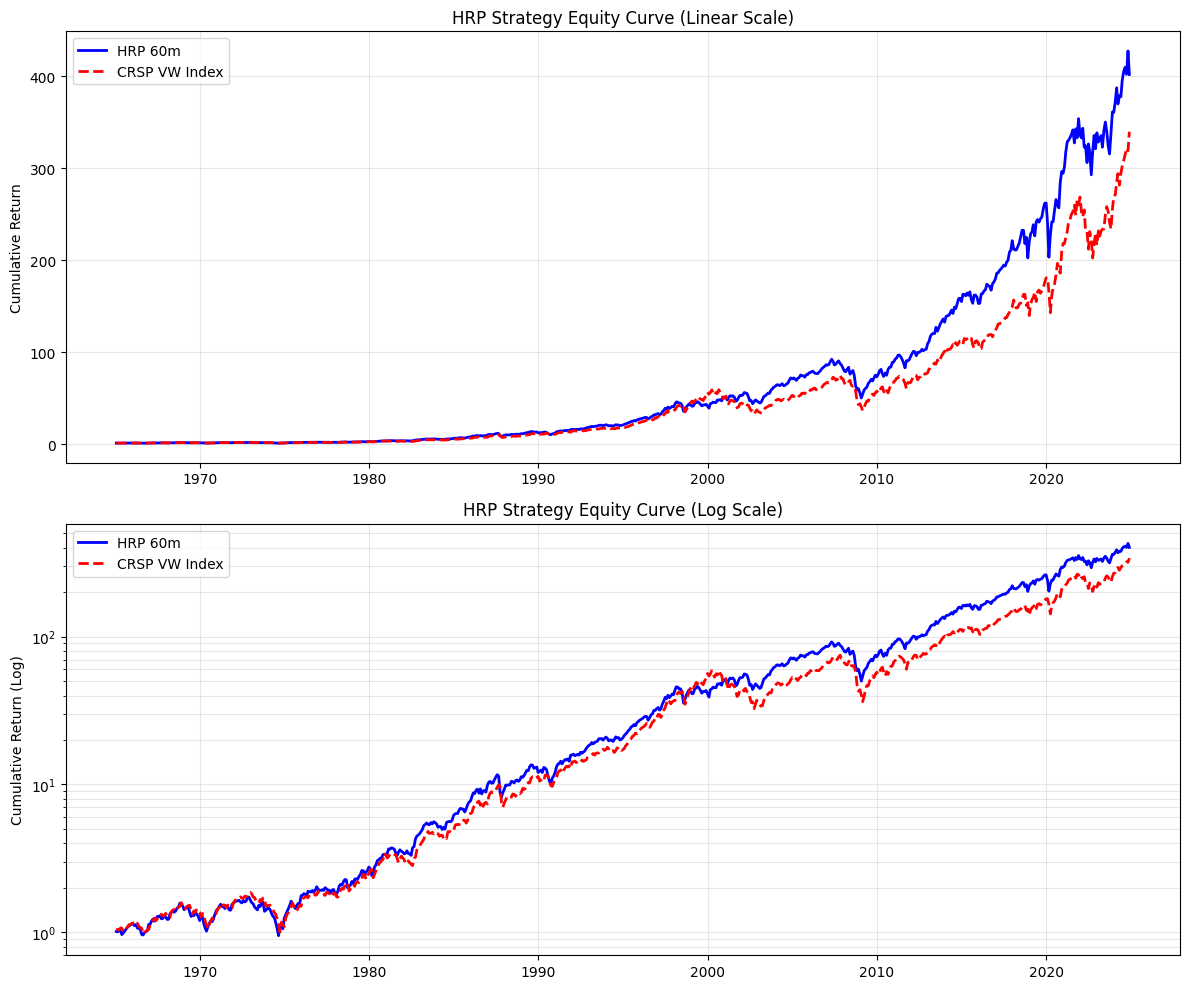

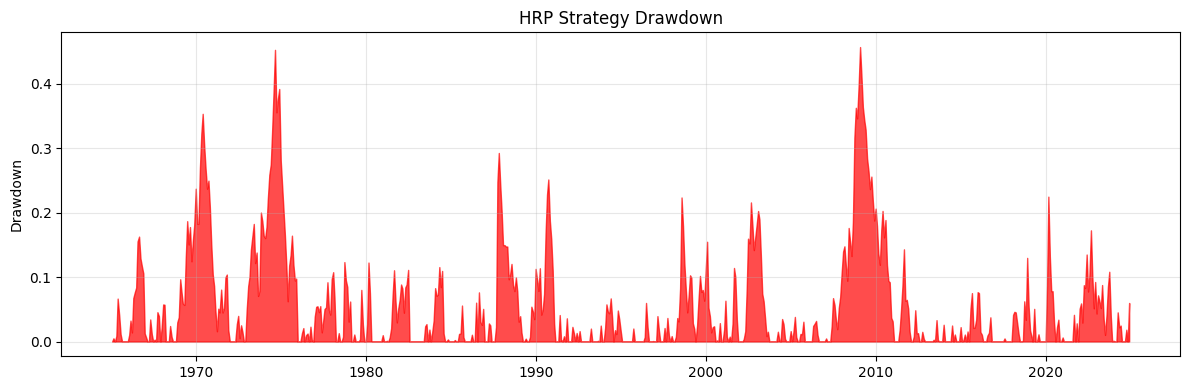


PERFORMANCE METRICS
Strategy                     HRP 60m
Total Excess Return       388.116367
Annualized Excess Return    0.060517
Sharpe Ratio                0.452664
Volatility (Ann.)           0.149886
Max Drawdown                0.142746
Calmar Ratio                0.737352
Win Rate                    0.617524
Avg Win                     0.035017
Avg Loss                   -0.032178
Best Month                  0.181900
Worst Month                -0.230046
Total Months              719.000000
2026-01-06 01:24:43,355 - HRP_Agent - INFO - [OK] Metrics saved to c:\Users\lucas\OneDrive\Bureau\HRP\Super_Agent_Output\final_metrics.csv


In [9]:
# Step 3: Backtest & Performance Metrics

# Load pre-computed strategy returns (in case Step 2 was skipped)
strategy_returns_path = os.path.join(super_agent_dir, 'hrp_strategy_returns.csv')
if os.path.exists(strategy_returns_path):
    print(f"Loading strategy returns from {strategy_returns_path}...")
    strategy_returns = pd.read_csv(strategy_returns_path, index_col=0, parse_dates=True).squeeze()

# Load risk-free rate if not already defined
if 'rf_monthly_aligned' not in dir():
    prep_path = os.path.join(project_root, 'DATA', 'CRSP')
    rf_monthly_aligned = hrp_data.load_risk_free_rate(prep_path, strategy_returns.index, start_date_str='1960-01-01')

# Load market returns (CRSP VW Index)
vw_returns_path = os.path.join(project_root, 'DATA', 'CRSP', 'CRSP_value_weighted_returns.csv')
df_vw = pd.read_csv(vw_returns_path, parse_dates=['date']).set_index('date').sort_index()
market_col = 'vwretd' if 'vwretd' in df_vw.columns else df_vw.columns[0]
market_returns = df_vw[market_col].dropna()

metrics_df = hrp_pipeline.run_backtest(
    strategy_returns, 
    rf_monthly_aligned, 
    super_agent_dir,
    market_returns=market_returns
)

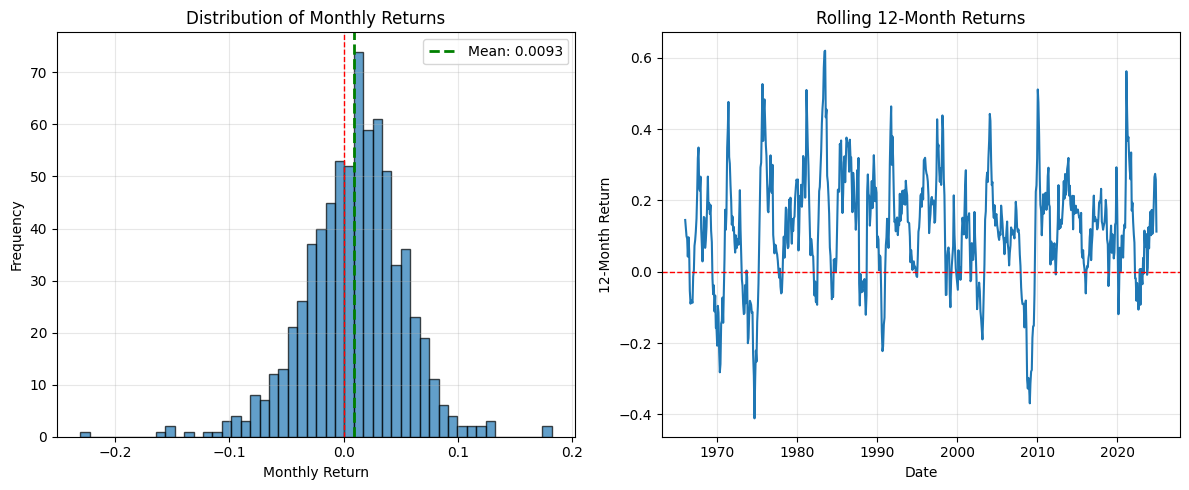

MONTHLY RETURNS DISTRIBUTION STATISTICS
Period: 1965-01 to 2024-12 (720 months)

Metric                     HRP Strategy      CRSP VW Index
------------------------------------------------------------
Mean (Monthly)                  0.932%            0.910%
Mean (Annualized)               11.18%            10.92%
Std (Monthly)                   4.327%            4.495%
Std (Annualized)                14.99%            15.57%
Skewness                         -0.426             -0.512
Excess Kurtosis                   2.357              1.789
Min (Monthly)                  -23.00%           -22.54%
Max (Monthly)                   18.19%            16.56%
------------------------------------------------------------

Interpretation:
  • HRP Strategy has MORE POSITIVE skew (-0.426 vs -0.512)
    → Fewer extreme negative returns, more upside potential
  • HRP Strategy has HIGHER kurtosis (2.357 vs 1.789)
    → Fatter tails, more frequent extreme events

Jarque-Bera Normality Test:
  • HRP St

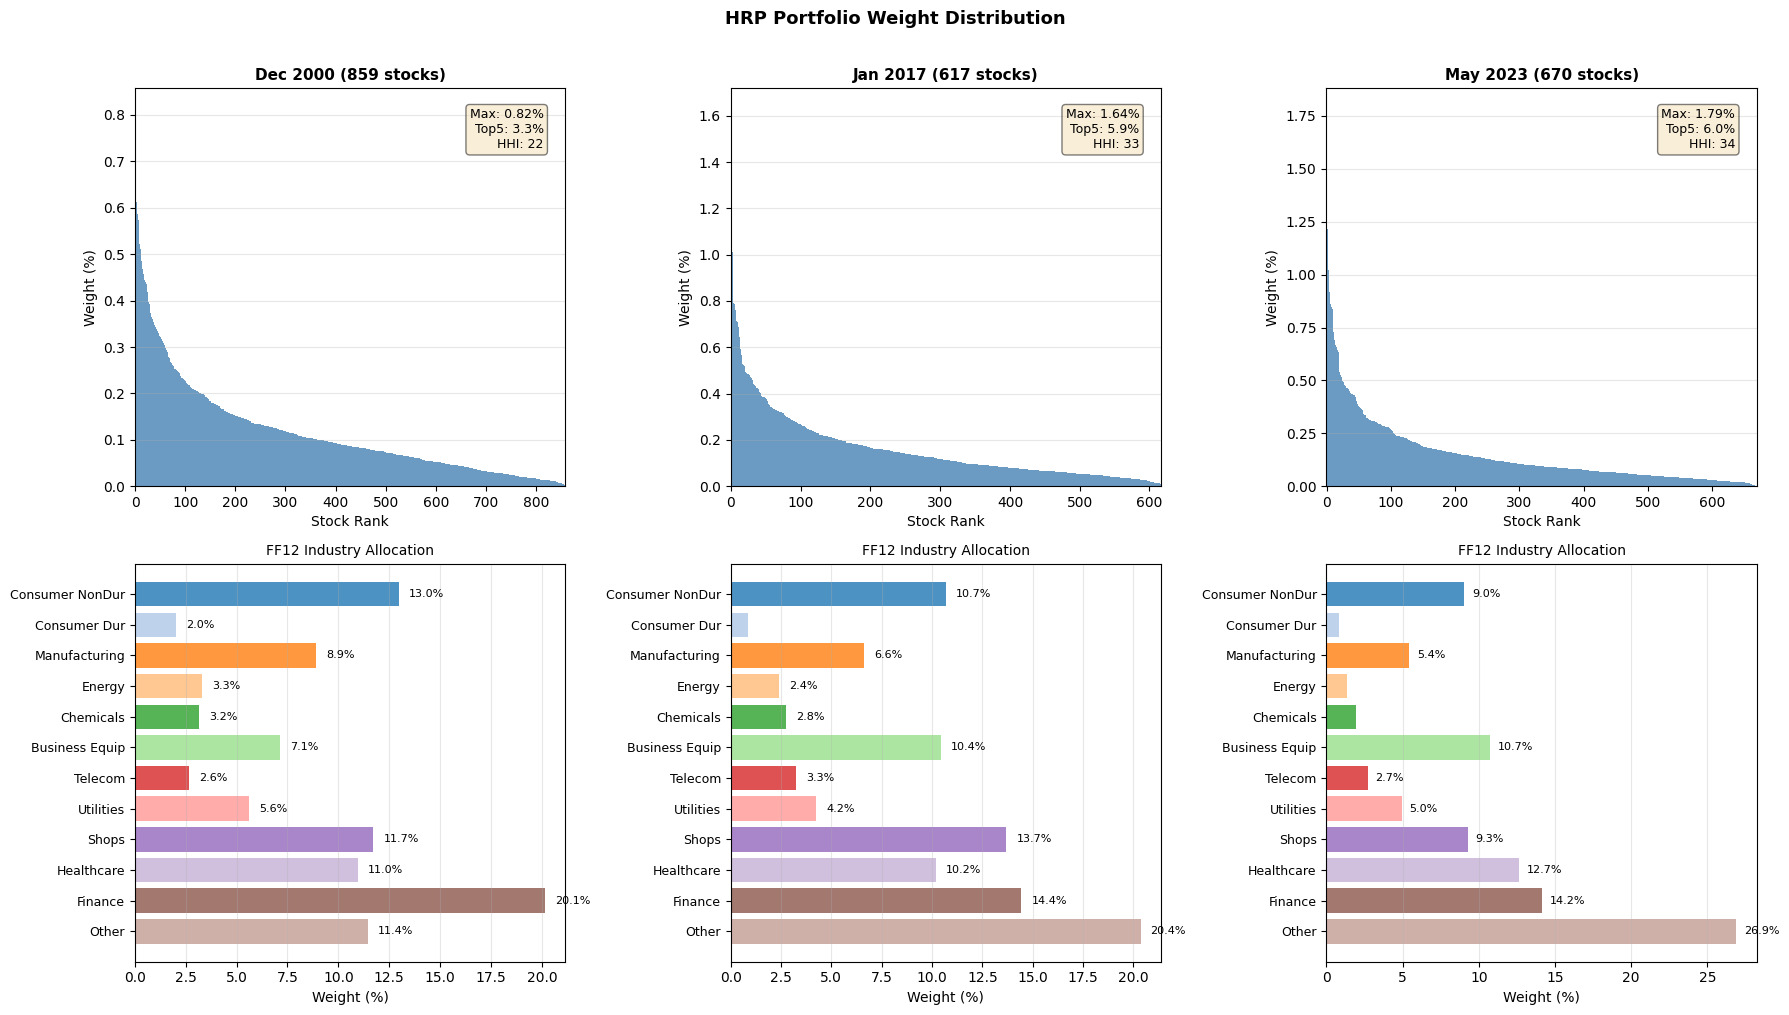


Weight Distribution Summary (3 Sample Months):

  Dec 2000: 859 stocks
    Max: 0.82%, Top5: 3.35%
    Top 3 Industries: Finance=20.1%, Consumer NonDur=13.0%, Shops=11.7%

  Jan 2017: 617 stocks
    Max: 1.64%, Top5: 5.89%
    Top 3 Industries: Other=20.4%, Finance=14.4%, Shops=13.7%

  May 2023: 670 stocks
    Max: 1.79%, Top5: 6.02%
    Top 3 Industries: Other=26.9%, Finance=14.2%, Healthcare=12.7%

Computing industry exposures over time...


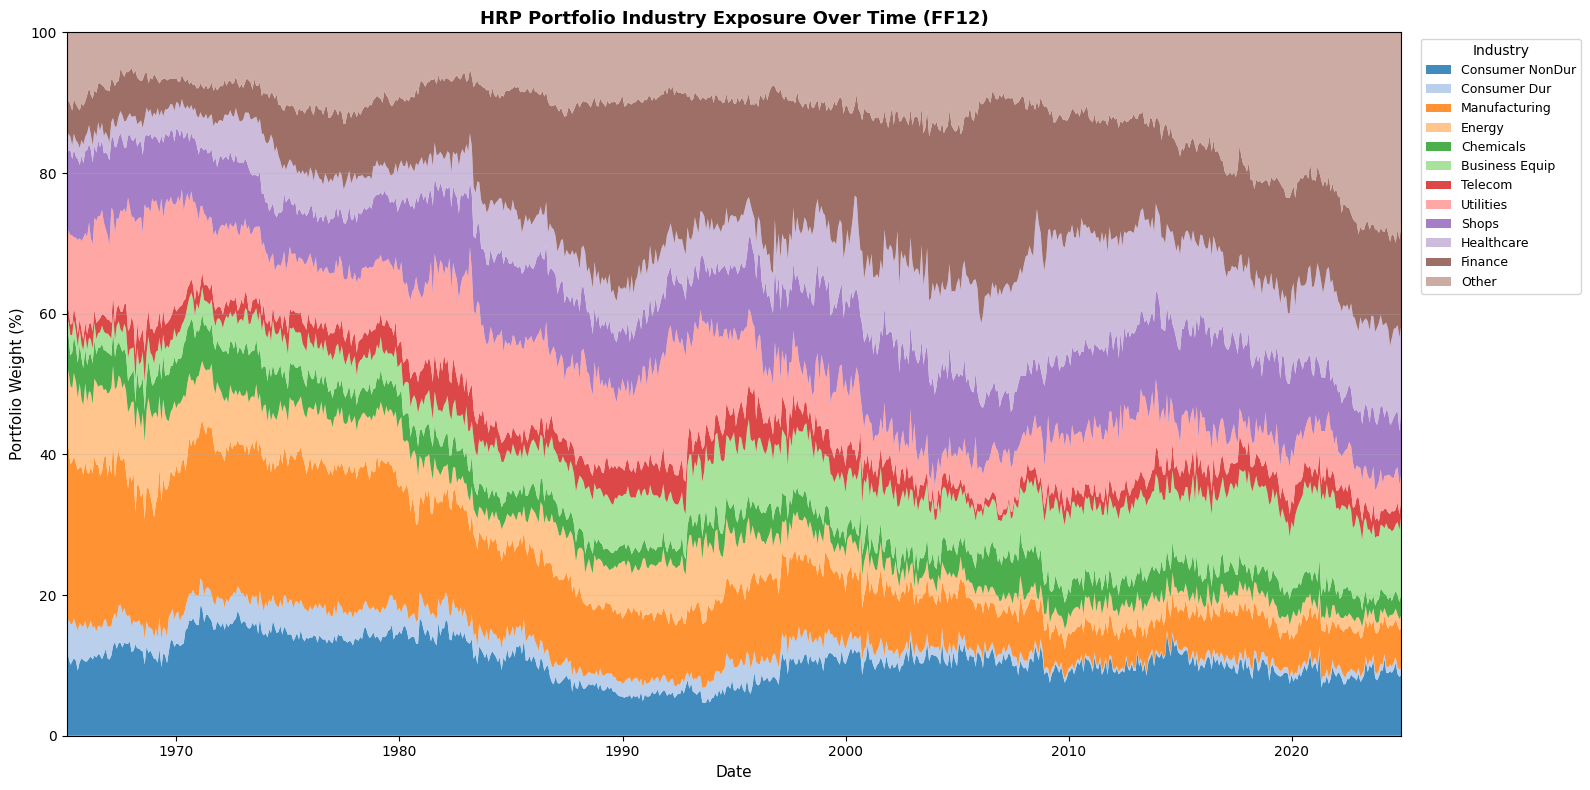


Average Industry Allocation (Full Period):
  Finance           : 14.9%
  Other             : 11.8%
  Manufacturing     : 11.6%
  Consumer NonDur   : 10.8%
  Shops             : 10.2%
  Utilities         : 9.6%
  Healthcare        : 8.9%
  Business Equip    : 7.5%
  Energy            : 5.3%
  Chemicals         : 3.9%
  Telecom           : 3.0%
  Consumer Dur      : 2.4%


In [10]:
# Step 4: Return Distribution & Weights Analysis
import matplotlib.pyplot as plt

# Plot returns distribution histogram
hrp_pipeline.plot_monthly_returns_distribution(strategy_returns, super_agent_dir)

# Load CRSP VW returns for comparison
vw_returns_path = os.path.join(project_root, 'DATA', 'CRSP', 'CRSP_value_weighted_returns.csv')
df_vw = pd.read_csv(vw_returns_path, parse_dates=['date']).set_index('date').sort_index()
market_col = 'vwretd' if 'vwretd' in df_vw.columns else df_vw.columns[0]
crsp_returns = df_vw[market_col].dropna()

# Print distribution statistics comparison (mean, std, skewness, kurtosis, Jarque-Bera)
importlib.reload(hrp_analytics)
hrp_analytics.print_distribution_comparison(strategy_returns, crsp_returns)

# ═══════════════════════════════════════════════════════════════════════════════
# WEIGHTS ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

# Load HRP weights
weights_path = os.path.join(super_agent_dir, 'all_hrp_weights.csv')
hrp_weights_df = pd.read_csv(weights_path, index_col=0, parse_dates=True)

# Load PERMNO to FF12 mapping
permno_to_ff12 = hrp_analytics.load_permno_to_ff12_mapping(project_root)

# Plot weight distributions for 3 sample months (stocks + industries)
hrp_analytics.plot_weight_distribution(
    hrp_weights_df, permno_to_ff12, super_agent_dir,
    sample_dates=['2000-12-31', '2017-01-31', '2023-05-31']
)

# Plot industry exposure over time (stacked area chart)
industry_df = hrp_analytics.plot_industry_exposure_over_time(
    hrp_weights_df, permno_to_ff12, super_agent_dir
)

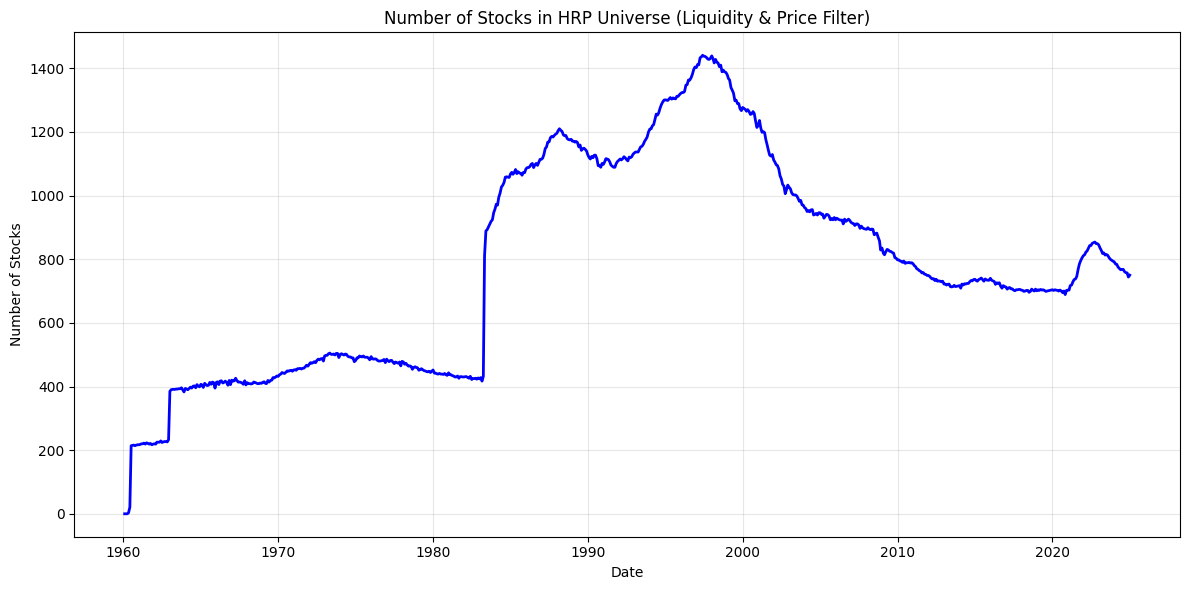

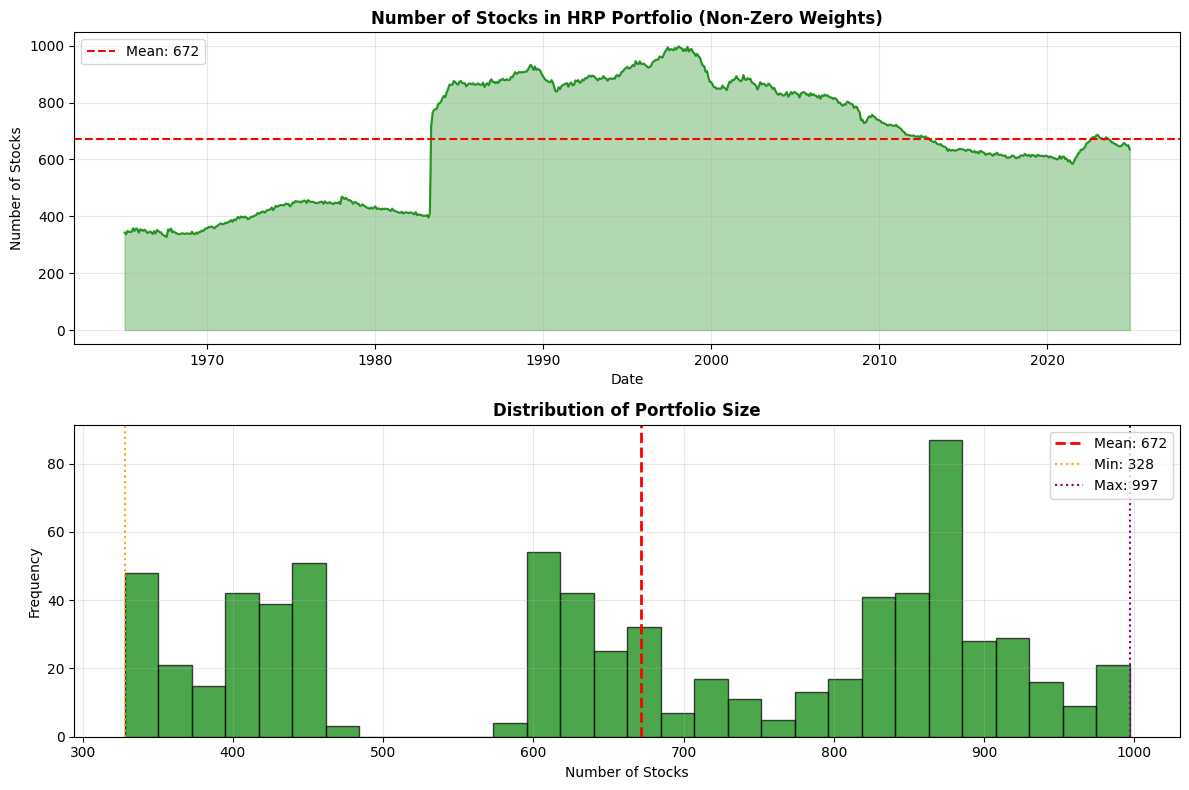


Portfolio Size Statistics:
  Mean:   671.7 stocks
  Median: 677.0 stocks
  Min:    328 stocks
  Max:    997 stocks
  Std:    206.5 stocks


In [11]:
# Step 5: Universe Size & Portfolio Size Analysis

# Plot universe size (stocks passing liquidity/price filter)
hrp_analytics.plot_universe_size(universe_flags, super_agent_dir)

# Plot portfolio size (stocks with non-zero weights) - reuses hrp_weights_df from Step 4
portfolio_counts = hrp_analytics.plot_portfolio_size(hrp_weights_df, super_agent_dir)

Plotting dendrogram for: 2023-12-29

PLOTTING DENDROGRAM: 2023-12-29 (Window: 60m)
Universe Size: 657 stocks


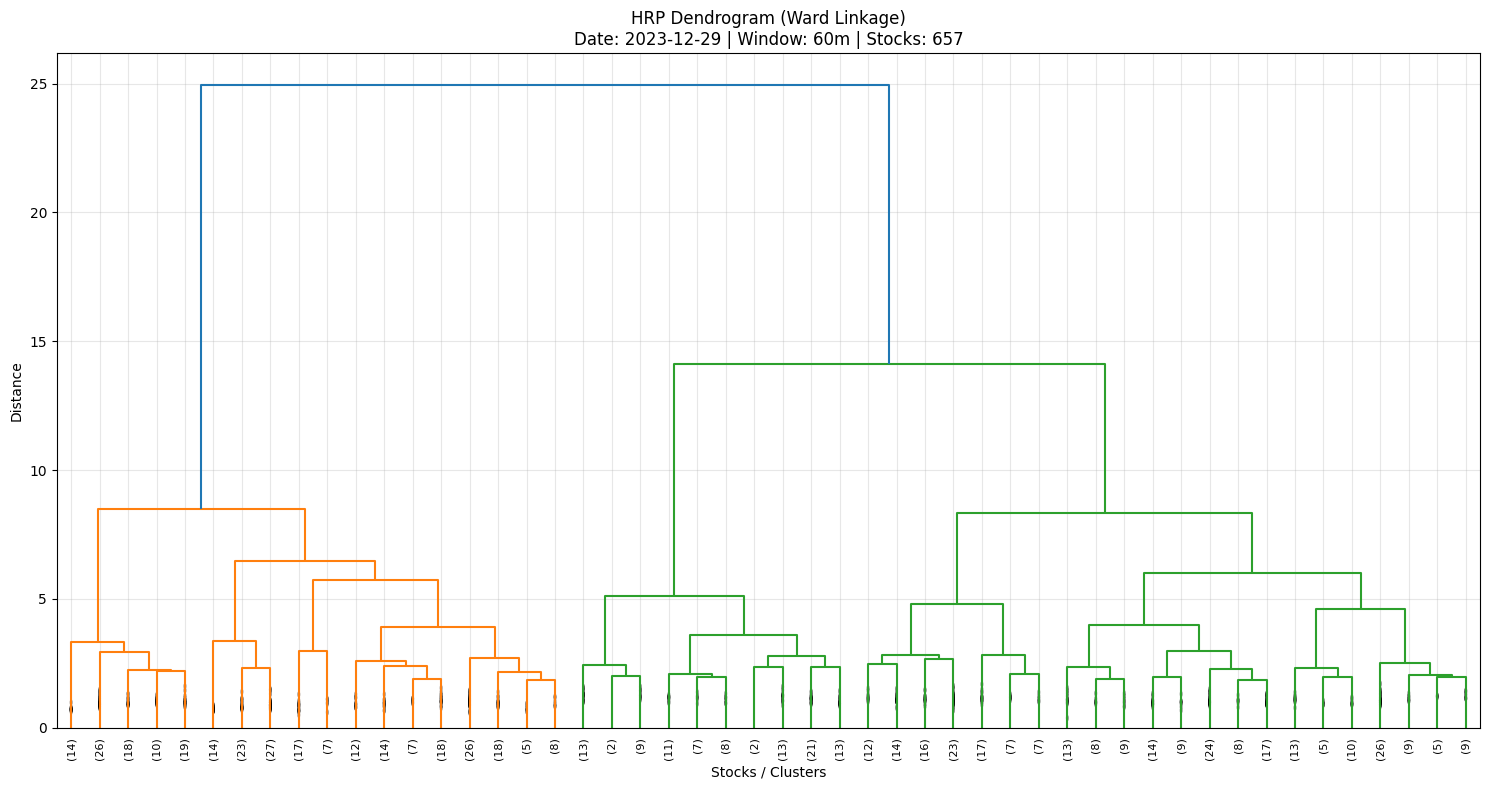

In [12]:
# Step 6: HRP Dendrogram Visualization

# Plot dendrogram for the last rebalance date of 2023
target_year = 2023
dates_2023 = [d for d in valid_rebal_dates if d.year == target_year]

if dates_2023:
    plot_date = dates_2023[-1]
    print(f"Plotting dendrogram for: {plot_date.date()}")
    hrp_analytics.plot_hrp_dendrogram(
        returns_all, 
        universe_flags, 
        plot_date, 
        window, 
        super_agent_dir
    )
else:
    print(f"No rebalance dates found for year {target_year}")

# Regime-Based HRP Strategy with XGBoost Prediction

## Prediction Goal: Will NEXT MONTH be Bear or Bull?

The XGBoost model predicts whether the upcoming month will be:
- **Bear (0)**: Negative expected returns, elevated volatility, correlation convergence
- **Bull/Consolidation (1)**: Positive expected returns, normal volatility, diversification works

## 6-Phase Implementation Plan

### Phase 1: Data Construction (HMM Input)
- Use **HRP strategy returns** (not CRSP VW index) — fits regimes to the actual traded strategy
- **3-Feature HMM Input** (all expanding Z-scored for no look-ahead bias):
  1. **Log Returns**: $r_t = \ln(1 + R_t)$
  2. **Downside Deviation** (6-month rolling window): $\sigma^-_t = \text{std}(\min(r_{t-5:t}, 0))$
  3. **Michigan Consumer Sentiment YoY Change** (lagged 1M for publication delay):
     $$\text{sent\_change}_t = \frac{ICS_t}{ICS_{t-12}} - 1, \quad \text{then } \text{shift}(1)$$
- **Expanding Z-score** (strictly ex-ante): $z_t = \frac{x_t - \bar{x}_{1:t-1}}{\sigma_{1:t-1}}$

### Phase 2: Regime Identification (HMM)
- Fit `hmmlearn.GaussianHMM` with **2 states** using **expanding window** (min 60 months, refit every 12 months)
- **Forward-Only Filter**: Compute $P(q_t | O_{1:t})$ using forward algorithm ONLY
- **Critical**: `hmmlearn.predict_proba()` uses forward-backward (smoothed posteriors = look-ahead bias!) — we implement a **custom forward filter** to avoid data leakage
- **State Sorting**: State 0 = Lower Mean Return (Bear), State 1 = Higher Mean Return (Bull)
- No data leakage: expanding z-score uses `shift(1)`, HMM trained only on past data

### Phase 3: Feature Engineering (Predictors)
- **14 Features** for XGBoost regime prediction:
  - *Market/Cross-sectional*: `dispersion_z`, `amihud_z`, `bab_z`, `avg_pairwise_corr_z`
  - *Macro*: `credit_spread`, `term_spread`, `cpi_vol`, `m2_growth`, `unrate_trend`, `valuation_spread_z`
  - *Technical*: `rsi`
  - *HRP Momentum*: `hrp_mom_1m_z`, `hrp_mom_3m_z`, `hrp_mom_12m_z`
- **Rolling Z-Score** with `shift(1)`: $z_t = \frac{x_t - \bar{x}_{t-W:t-1}}{\sigma_{t-W:t-1}}$ (strictly ex-ante)
- **Lagging**: Features at time $t$ predict regime at time $t+1$

### Phase 3.5: Feature Overview (Display Only)
- Lists all candidate features with correlations to next month's regime
- **No selection here** — moved inside walk-forward loop (Phase 4)

### Phase 4: Walk-Forward Backtesting (Predict Bear/Bull)
- **Purged Time-Series CV** for all cross-validation (`purge_gap=12` months, `embargo_pct=1%`)
- **Feature selection INSIDE walk-forward loop** — avoids look-ahead bias
- **Hyperparameter tuning INSIDE walk-forward loop** (20 Optuna trials per refit)
- **Winsorization INSIDE walk-forward loop** — bounds computed from training data only
- Start at Month 120 (Year 10), refit every 12 months

### Phase 5: HRP Integration (GROSS Returns)
- **Two-Fund Separation**: $r_{portfolio} = L_t \times r_{HRP} + (1-L_t) \times r_f$
- **P(Bull) Scaled Strategy**: $L_t = P(Bull_t) \times \frac{1}{\bar{P}(Bull)}$ ensures mean leverage ≈ 1
- **Leverage interpretation**: $L > 1$ = borrow at $r_f$; $L < 1$ = hold T-Bills defensively
- **GROSS returns**: No transaction costs, borrow at $r_f$ (no financing spread)

### Phase 6: Transaction Cost Analysis (NET Returns)
- **Inner Cost** (HRP Rebalancing): Drift-adjusted turnover × cost per trade
  $$\text{inner}_t = L_t \times \sum_i |w_{i,t}^{target} - w_{i,t}^{drifted}| \times C_{bps}$$
- **Outer Cost** (Leverage Overlay): Both sides of HRP ↔ T-Bill trade
  $$\text{outer}_t = 2 \times |L_t - L_{t-1}| \times C_{bps}$$
- **Financing Cost** (Asymmetric): Pay spread only when leveraged ($L > 1$)
  $$\text{financing}_t = \max(L_t - 1, 0) \times \text{spread}_{bps}$$
- **NET Returns**: $r_{NET} = r_{GROSS} - \text{inner} - \text{outer} - \text{financing}$

In [71]:
# ═══════════════════════════════════════════════════════════════════════════════
# ML PHASES: DATA PREPARATION
# ═══════════════════════════════════════════════════════════════════════════════
# Note: This cell reuses data loaded in Steps 1-4 (returns_all, universe_flags, etc.)
# Only loads ML-specific modules and computes ML features

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import ML modules
import hrp_features
import hrp_hmm
import hrp_ml
import hrp_strategy
import hrp_viz

# Reload modules to pick up any changes
importlib.reload(hrp_features)
importlib.reload(hrp_hmm)
importlib.reload(hrp_viz)

# Reload config to get ML parameters
config = hrp_setup.load_config(project_root)

# Extract ML config sections
hmm_config = config.get('hmm', {})
ml_config = config.get('ml', {})
strategy_config = config.get('strategy', {})
vol_config = config.get('vol_targeting', {})

print("="*70)
print("ML CONFIGURATION (from config.yaml)")
print("="*70)
print(f"HMM: min_train={hmm_config.get('min_train', 60)}, refit_freq={hmm_config.get('refit_freq', 12)}")
print(f"ML:  min_train={ml_config.get('min_train_months', 120)}, optuna_trials={ml_config.get('optuna_trials', 50)}")
print(f"Strategy: tx_cost={strategy_config.get('tx_cost_bps', 10)}bps, bear_alloc={strategy_config.get('bear_allocation', 0.5)}")
print(f"Vol Target: target={vol_config.get('target_vol', 0.15):.0%}, leverage=[{vol_config.get('min_leverage', 0.25)}, {vol_config.get('max_leverage', 2.0)}]")

# Load CRSP VW returns for HMM (market_returns loaded in Step 3, but need full series)
vw_returns_path = os.path.join(project_root, 'DATA', 'CRSP', 'CRSP_value_weighted_returns.csv')
df_vw = pd.read_csv(vw_returns_path, parse_dates=['date']).set_index('date').sort_index()
market_col = 'vwretd' if 'vwretd' in df_vw.columns else df_vw.columns[0]
market_returns_full = df_vw[market_col].dropna()
market_returns_full = market_returns_full.resample('ME').last()
full_range = pd.date_range(start=market_returns_full.index.min(), end=market_returns_full.index.max(), freq='ME')
market_returns_full = market_returns_full.reindex(full_range).ffill()
print(f"\n✓ Market Returns: {len(market_returns_full)} months")

# Compute ML features (uses df_ml_universe from Step 1)
fred_path = os.path.join(project_root, 'DATA', 'FRED')
macro_df = hrp_data.load_fred_data(fred_path, start_date_str='1960-01-01')

# Load Compustat for valuation spread
df_merged_comp = None
comp_path = os.path.join(project_root, 'DATA', 'Compustat', 'compustat_selected_columns.csv')
if os.path.exists(comp_path):
    comp_df = pd.read_csv(comp_path, parse_dates=['datadate'])
    comp_df = comp_df.rename(columns={'LPERMNO': 'PERMNO'})
    if 'seqq' in comp_df.columns:
        comp_df['BOOK_EQUITY'] = comp_df['seqq']
        comp_df = comp_df[comp_df['BOOK_EQUITY'].notna() & (comp_df['BOOK_EQUITY'] > 0)]
        df_merged_comp = df_ml_universe.merge(
            comp_df[['PERMNO', 'datadate', 'BOOK_EQUITY']], 
            left_on=['PERMNO', 'DATE'], right_on=['PERMNO', 'datadate'], how='left'
        )
        print(f"✓ Compustat data loaded")

ml_features = hrp_features.compute_all_features(df_ml_universe, macro_df, df_merged_comp)
print(f"✓ ML Features (Market/Macro): {ml_features.shape[0]} obs × {ml_features.shape[1]} features")

# Reuse hrp_weights_df from Step 4 (rename for ML phases)
hrp_weights = hrp_weights_df.copy()
print(f"✓ HRP Weights: {hrp_weights.shape[0]} months × {hrp_weights.shape[1]} assets")

# ═══════════════════════════════════════════════════════════════════════════════
# COMPUTE HRP MOMENTUM FEATURES (1M, 3M, 12M Z-scored)
# ═══════════════════════════════════════════════════════════════════════════════
# These are strategy-specific features that capture time-series momentum
# in the HRP portfolio itself - useful for predicting regime persistence
# NOTE: Using 24-month Z-score window (not 60) to minimize data loss
#       12M momentum + 24M zscore + 1 shift = ~37 months burn-in (acceptable)

hrp_momentum_features = hrp_features.compute_hrp_momentum_features(strategy_returns, zscore_window=24)

# Normalize dates to month-end for merging
hrp_momentum_features.index = hrp_momentum_features.index.to_period('M').to_timestamp('M')
ml_features.index = pd.to_datetime(ml_features.index).to_period('M').to_timestamp('M')

# ═══════════════════════════════════════════════════════════════════════════════
# FIX: Remove duplicate dates after month-end normalization
# Multiple dates in the same month (e.g., 1960-01-29, 1960-01-31) become duplicates
# when converted to month-end. Keep only the last occurrence.
# ═══════════════════════════════════════════════════════════════════════════════
n_dups_before = ml_features.index.duplicated().sum()
if n_dups_before > 0:
    print(f"  ⚠ Removing {n_dups_before} duplicate dates after month-end normalization")
    ml_features = ml_features[~ml_features.index.duplicated(keep='last')]

# Merge HRP momentum features with other ML features
ml_features = ml_features.join(hrp_momentum_features, how='left')

print(f"✓ ML Features (with HRP Momentum): {ml_features.shape[0]} obs × {ml_features.shape[1]} features")
print(f"  Columns: {list(ml_features.columns)}")

# ═══════════════════════════════════════════════════════════════════════════════
# LOAD MICHIGAN CONSUMER SENTIMENT (for HMM Phase 1)
# ═══════════════════════════════════════════════════════════════════════════════
# Sentiment is lagged 1 month in hrp_hmm to account for publication delay
umich_sentiment = hrp_hmm.load_umich_sentiment(fred_path)

print("\n" + "="*70)
print("DATA PREPARATION COMPLETE")
print("="*70)

✓ Loaded configuration from c:\Users\lucas\OneDrive\Bureau\HRP\config.yaml
✓ Random seeds set to 42
ML CONFIGURATION (from config.yaml)
HMM: min_train=60, refit_freq=12
ML:  min_train=120, optuna_trials=50
Strategy: tx_cost=10bps, bear_alloc=0.5
Vol Target: target=15%, leverage=[0.25, 2.0]

✓ Market Returns: 1188 months
✓ Loaded BAA from BAA.csv
✓ Loaded DGS10 from DGS10.csv
✓ Loaded CPI from CPIAUCSL.csv
✓ Loaded M2SL from M2SL.csv
✓ Loaded UNRATE from UNRATE.csv
✓ Loaded TB3MS from TB3MS.csv
✓ Compustat data loaded
2026-01-06 13:48:00,477 - HRP_Agent - INFO - Computing advanced features...
2026-01-06 13:48:01,406 - HRP_Agent - WARNING -   [!] Global: Found duplicates in universe. Dropping duplicates (keeping first)...
2026-01-06 13:48:03,010 - HRP_Agent - INFO -   - Dispersion (std of returns)
2026-01-06 13:48:04,169 - HRP_Agent - INFO -   - Amihud Illiquidity
2026-01-06 13:48:07,282 - HRP_Agent - INFO -   - VIX Proxy (Vol Regime)
  - Computing BAB Factor (Vectorized)...
2026-01-06 1

PHASE 1: DATA CONSTRUCTION
HRP Strategy Returns: 720 months
Date Range: 1965-01-29 to 2024-12-31
2026-01-06 13:49:16,450 - HRP_Agent - INFO - Preparing HMM data from 720 observations
2026-01-06 13:49:16,453 - HRP_Agent - INFO - Using EXPANDING Z-SCORE (no look-ahead bias)
2026-01-06 13:49:17,355 - HRP_Agent - INFO - Adding UMICH Consumer Sentiment to HMM features
2026-01-06 13:49:17,364 - HRP_Agent - INFO - Computed sentiment features: sent_change, sent_gap (lagged 1M for publication)
2026-01-06 13:49:17,377 - HRP_Agent - INFO - Sentiment coverage: 713 months
2026-01-06 13:49:17,383 - HRP_Agent - INFO - HMM input data: 712 observations after dropping NaN
2026-01-06 13:49:17,387 - HRP_Agent - INFO - Date range: 1965-08-31 to 2024-11-29
2026-01-06 13:49:17,406 - HRP_Agent - INFO - Added sent_change_z to HMM input (3 features total)
2026-01-06 13:49:17,415 - HRP_Agent - INFO - After expanding z-score burn-in: 688 observations
2026-01-06 13:49:17,418 - HRP_Agent - INFO - HMM features: ['lo

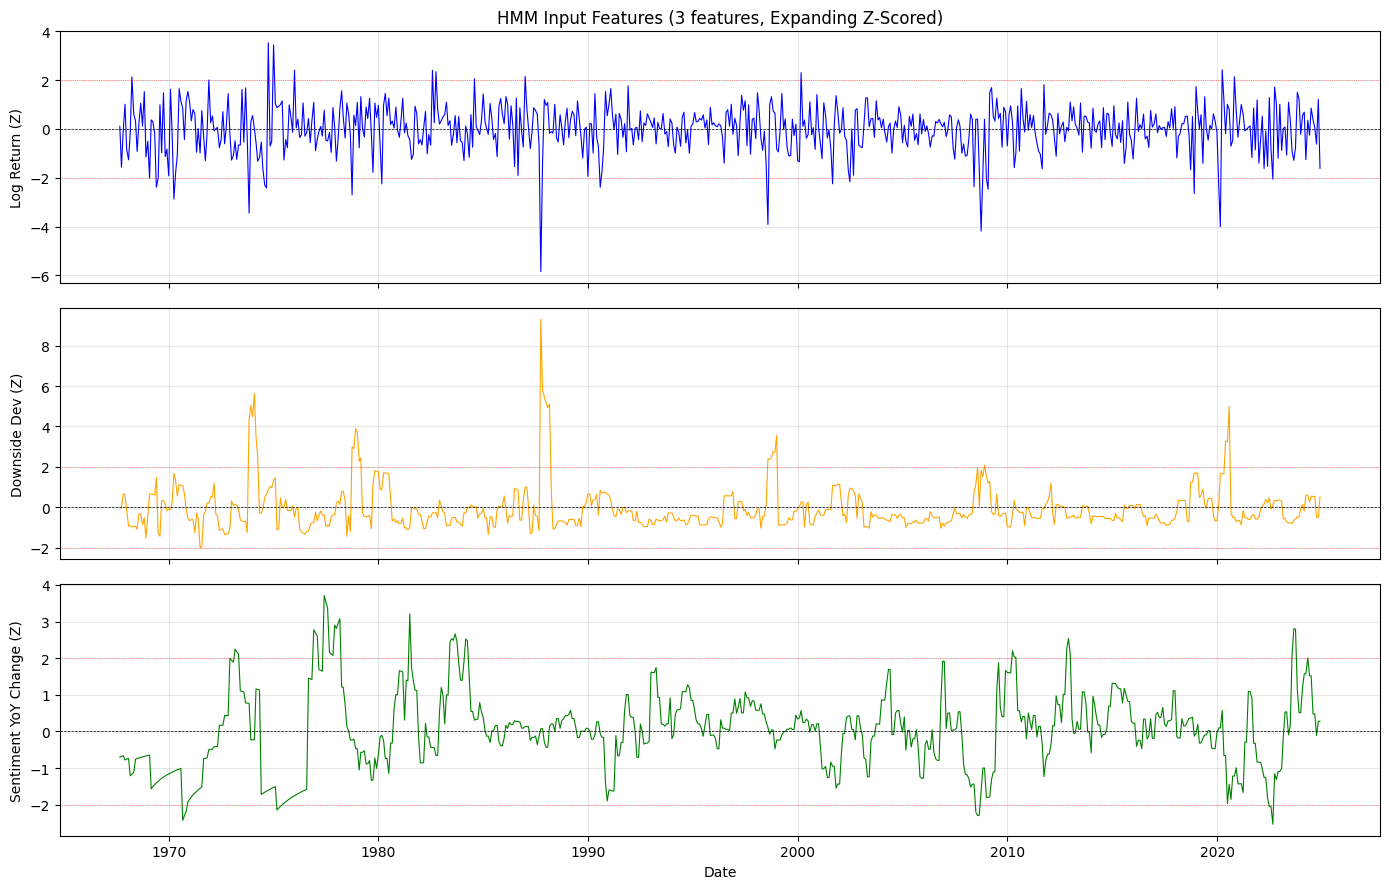


✓ Phase 1 Complete: HMM input prepared (688 observations)
  Features: ['log_return_z', 'downside_dev_z', 'sent_change_z']
  NOTE: Using HRP strategy returns + UMICH Consumer Sentiment (lagged 1M)


In [72]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 1: DATA CONSTRUCTION (Ground Truth Definition)
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("PHASE 1: DATA CONSTRUCTION")
print("="*70)

# Use HRP strategy returns for HMM regime detection (instead of CRSP VW index)
# This fits regimes to the actual strategy being traded
hrp_returns_for_hmm = strategy_returns.copy()
hrp_returns_for_hmm.index = pd.to_datetime(hrp_returns_for_hmm.index)

print(f"HRP Strategy Returns: {len(hrp_returns_for_hmm)} months")
print(f"Date Range: {hrp_returns_for_hmm.index.min().date()} to {hrp_returns_for_hmm.index.max().date()}")

# Prepare HMM input data (log returns + downside deviation + sentiment YoY change)
# umich_sentiment loaded in DATA PREPARATION cell above
downside_window = hmm_config.get('downside_window', 12)
df_hmm_raw, df_hmm = hrp_hmm.prepare_hmm_data(
    hrp_returns_for_hmm, 
    downside_window=downside_window,
    sentiment=umich_sentiment  # Adds sent_change_z as 3rd HMM feature
)

# Visualize HMM input
fig = hrp_viz.plot_hmm_input(df_hmm)
plt.show()

print(f"\n✓ Phase 1 Complete: HMM input prepared ({len(df_hmm)} observations)")
print(f"  Features: {list(df_hmm.columns)}")
print("  NOTE: Using HRP strategy returns + UMICH Consumer Sentiment (lagged 1M)")

PHASE 2: REGIME IDENTIFICATION (HMM)
Using TRUE FILTERED probabilities: P(q_t | O_1:t)
Forward algorithm ONLY - no backward pass, no look-ahead bias

NOTE: hmmlearn's predict_proba() uses forward-backward (smoothed posteriors)
      which leaks future information. We implement forward-only filter.

Config: min_train=60, refit_freq=12
2026-01-06 13:49:19,346 - HRP_Agent - INFO - ======================================================================
2026-01-06 13:49:19,349 - HRP_Agent - INFO - EXPANDING-WINDOW HMM FITTING (TRUE FILTERED PROBABILITIES)
2026-01-06 13:49:19,352 - HRP_Agent - INFO - ======================================================================
2026-01-06 13:49:19,359 - HRP_Agent - INFO - Using FORWARD-ONLY filter: P(q_t | O_1:t) - NO look-ahead bias
2026-01-06 13:49:19,363 - HRP_Agent - INFO - Min training: 60 months, Refit frequency: 12 months


Expanding HMM (Forward Filter):   7%|▋         | 47/628 [00:02<00:44, 13.16it/s]

2026-01-06 13:51:17,500 - HRP_Agent - INFO - Regime labels: 628 months (154 Bear, 474 Bull)



df_regimes columns: ['regime', 'prob_bear', 'prob_bull', 'log_return', 'downside_dev', 'regime_label']
Regime value counts: {1: 474, 0: 154}

Regime Statistics:

Bear:
  Months: 154 (24.5%)
  Annualized Return: 4.51%
  Expected Duration: 6.7 months

Bull:
  Months: 474 (75.5%)
  Annualized Return: 13.31%
  Expected Duration: 20.6 months

Transition Matrix:
           To Bear  To Bull
From Bear    0.851    0.149
From Bull    0.049    0.951


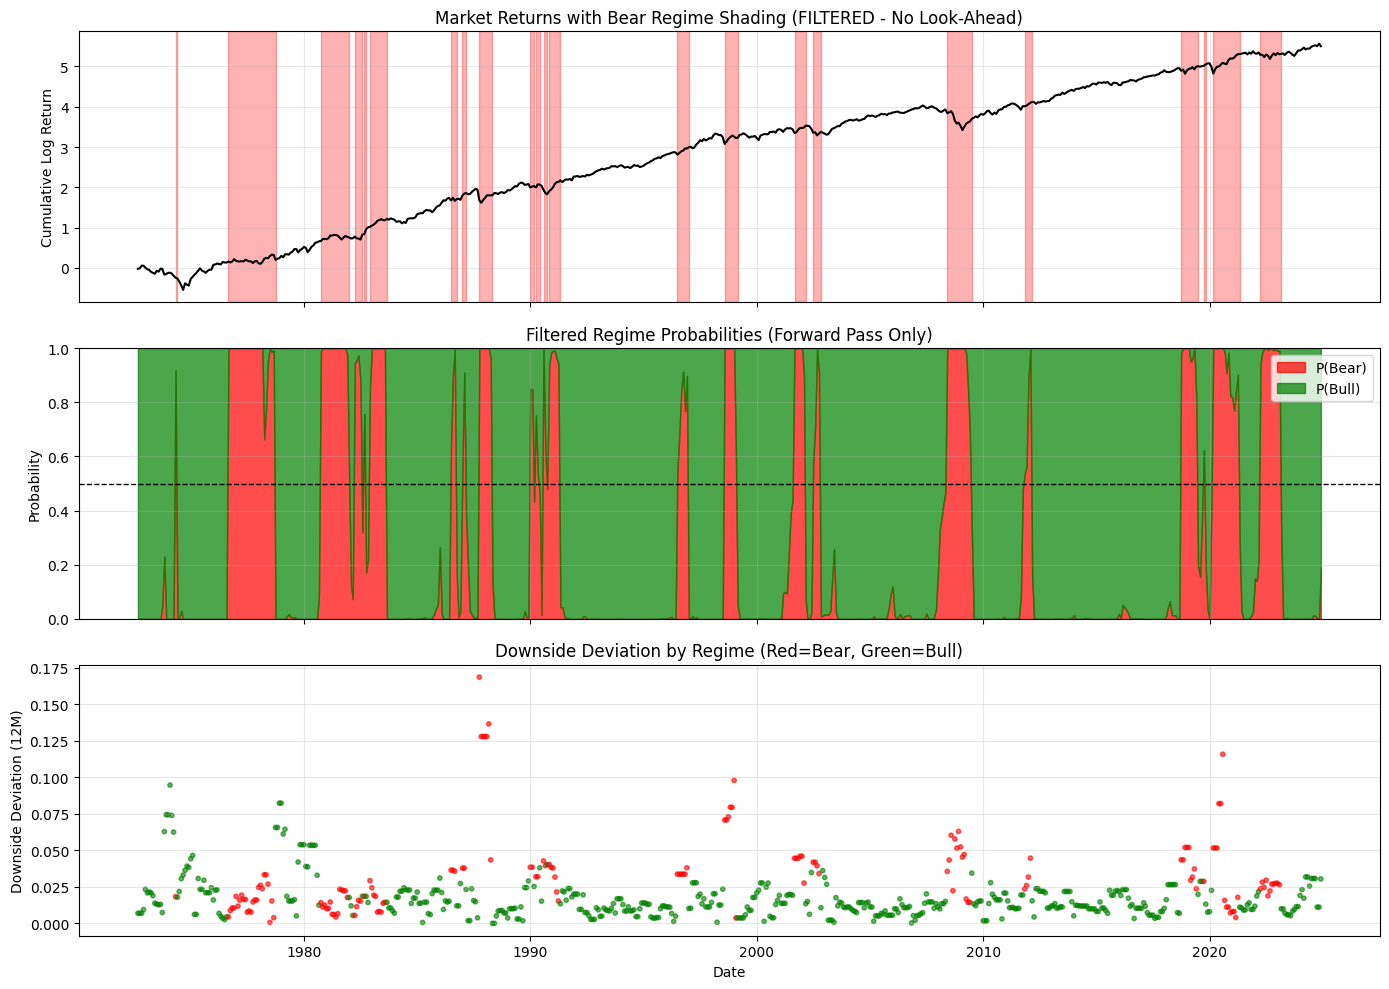


✓ Phase 2 Complete: 628 months labeled (TRUE filtered probabilities)


In [73]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 2: REGIME IDENTIFICATION (HMM) - TRUE FILTERED PROBABILITIES
# ═══════════════════════════════════════════════════════════════════════════════

# Reload hrp_hmm to pick up the forward-only filter fix
importlib.reload(hrp_hmm)

print("="*70)
print("PHASE 2: REGIME IDENTIFICATION (HMM)")
print("="*70)
print("Using TRUE FILTERED probabilities: P(q_t | O_1:t)")
print("Forward algorithm ONLY - no backward pass, no look-ahead bias")
print("")
print("NOTE: hmmlearn's predict_proba() uses forward-backward (smoothed posteriors)")
print("      which leaks future information. We implement forward-only filter.")

# Configuration from config.yaml
HMM_MIN_TRAIN = hmm_config.get('min_train', 60)
HMM_REFIT_FREQ = hmm_config.get('refit_freq', 12)

print(f"\nConfig: min_train={HMM_MIN_TRAIN}, refit_freq={HMM_REFIT_FREQ}")

# Fit expanding-window HMM with TRUE filtered probabilities
df_regimes = hrp_hmm.fit_expanding_hmm(
    df_hmm, df_hmm_raw,
    min_train=HMM_MIN_TRAIN,
    refit_freq=HMM_REFIT_FREQ
)

# Debug: Check df_regimes structure
print(f"\ndf_regimes columns: {df_regimes.columns.tolist()}")
print(f"Regime value counts: {df_regimes['regime'].value_counts().to_dict()}")

# Get regime statistics
regime_stats = hrp_hmm.get_regime_statistics(df_regimes)

print(f"\nRegime Statistics:")
for regime_name in ['Bear', 'Bull']:
    stats = regime_stats[regime_name]
    print(f"\n{regime_name}:")
    print(f"  Months: {stats['months']} ({stats['pct']:.1%})")
    print(f"  Annualized Return: {stats['ann_return']:.2%}")
    print(f"  Expected Duration: {stats['expected_duration']:.1f} months")

print(f"\nTransition Matrix:")
print(regime_stats['transition_matrix'].round(3))

# Visualize regimes
fig = hrp_viz.plot_hmm_regimes(df_regimes, 
    save_path=os.path.join(super_agent_dir, 'phase2_hmm_regimes.png'))
plt.show()

print(f"\n✓ Phase 2 Complete: {len(df_regimes)} months labeled (TRUE filtered probabilities)")

In [74]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 3: FEATURE ENGINEERING (Predictors for Bear/Bull Prediction)
# ═══════════════════════════════════════════════════════════════════════════════
# Goal: Build features at time t to predict if t+1 is Bear (0) or Bull (1)

print("="*70)
print("PHASE 3: FEATURE ENGINEERING")
print("="*70)
print("Goal: Features at time t → Predict Bear/Bull at time t+1")

# Define features (Z-scored in hrp_features.py, except RSI which is already 0-100)
# Now includes HRP strategy momentum features (1M, 3M, 12M)
FEATURE_COLS = [
    # Market/Cross-sectional features
    'dispersion_z', 'amihud_z', 'bab_z', 'avg_pairwise_corr_z',
    # Macro features
    'credit_spread', 'term_spread', 'cpi_vol', 'm2_growth', 
    'unrate_trend', 'valuation_spread_z', 
    # Technical indicator
    'rsi',
    # HRP Strategy Momentum (time-series momentum of the strategy itself)
    'hrp_mom_1m_z',   # 1-month HRP return (Z-scored)
    'hrp_mom_3m_z',   # 3-month cumulative HRP return (Z-scored)
    'hrp_mom_12m_z'   # 12-month cumulative HRP return (Z-scored)
]

# Filter to available features
available_features = [f for f in FEATURE_COLS if f in ml_features.columns]
missing_features = [f for f in FEATURE_COLS if f not in ml_features.columns]
print(f"Available Features: {len(available_features)}/{len(FEATURE_COLS)}")
if missing_features:
    print(f"  Missing: {missing_features}")

# Prepare feature matrix (NO global winsorization - moved to walk-forward loop)
# Winsorization now happens INSIDE walk_forward_predict() using training bounds only
X_features = ml_features[available_features].dropna()
print("NOTE: Winsorization moved to walk-forward loop (no look-ahead bias)")

# ═══════════════════════════════════════════════════════════════════════════════
# FIX: Normalize df_regimes index to month-end for proper alignment
# df_regimes has dates like '1972-12-29' (last business day)
# ml_features has dates like '1972-12-31' (month-end)
# Without this normalization, intersection loses ~170 dates!
# ═══════════════════════════════════════════════════════════════════════════════
df_regimes_aligned = df_regimes.copy()
df_regimes_aligned.index = df_regimes_aligned.index.to_period('M').to_timestamp('M')
print(f"df_regimes normalized to month-end: {len(df_regimes_aligned)} months")

# Align with regimes and create prediction target
# y_final[t] = regime at t+1 (what we're trying to predict)
X_final, y_final = hrp_ml.align_features_with_regimes(X_features, df_regimes_aligned, lag=1)

print(f"\nDataset: {len(X_final)} observations")
print(f"Target (NEXT MONTH): Bear={sum(y_final==0)}, Bull={sum(y_final==1)}")

# Feature correlation with target (next month's regime)
print("\nFeature Correlations with NEXT MONTH's Regime:")
target_corr = X_final.corrwith(y_final).sort_values()
for feat, corr in target_corr.items():
    direction = "→ Bull next month" if corr > 0 else "→ Bear next month"
    print(f"  {feat}: {corr:+.3f} ({direction})")

print(f"\n✓ Phase 3 Complete: {len(available_features)} features prepared")

PHASE 3: FEATURE ENGINEERING
Goal: Features at time t → Predict Bear/Bull at time t+1
Available Features: 14/14
NOTE: Winsorization moved to walk-forward loop (no look-ahead bias)
df_regimes normalized to month-end: 628 months
2026-01-06 13:51:22,148 - HRP_Agent - INFO - Aligned data: 576 observations
2026-01-06 13:51:22,200 - HRP_Agent - INFO - Target distribution: Bear=149, Bull=427

Dataset: 576 observations
Target (NEXT MONTH): Bear=149, Bull=427

Feature Correlations with NEXT MONTH's Regime:
  amihud_z: -0.313 (→ Bear next month)
  m2_growth: -0.284 (→ Bear next month)
  credit_spread: -0.281 (→ Bear next month)
  avg_pairwise_corr_z: -0.280 (→ Bear next month)
  dispersion_z: -0.225 (→ Bear next month)
  unrate_trend: -0.209 (→ Bear next month)
  valuation_spread_z: -0.167 (→ Bear next month)
  cpi_vol: -0.115 (→ Bear next month)
  term_spread: -0.103 (→ Bear next month)
  bab_z: -0.027 (→ Bear next month)
  rsi: +0.048 (→ Bull next month)
  hrp_mom_1m_z: +0.085 (→ Bull next mon

In [75]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 3.5: FEATURE OVERVIEW (Feature Selection in Walk-Forward)
# ═══════════════════════════════════════════════════════════════════════════════

# Reload hrp_ml to pick up walk-forward feature selection changes
importlib.reload(hrp_ml)

print("="*70)
print("PHASE 3.5: FEATURE OVERVIEW")
print("="*70)
print("NOTE: Feature selection happens INSIDE walk-forward to avoid look-ahead bias")
print("      This shows all candidate features before selection")

# Configuration from config.yaml
PURGE_GAP = ml_config.get('purge_gap', 12)  # Match vol lookback
EMBARGO_PCT = ml_config.get('embargo_pct', 0.01)
IMPORTANCE_THRESHOLD = ml_config.get('importance_threshold', 0.0)
SELECT_IN_WF = ml_config.get('select_features_in_wf', True)

print(f"\nConfig: purge_gap={PURGE_GAP}M, embargo_pct={EMBARGO_PCT:.1%}")
print(f"Feature selection in walk-forward: {SELECT_IN_WF}")

# Display all candidate features (no selection here)
print(f"\nCandidate Features ({len(X_final.columns)}) for Bear/Bull Prediction:")
for i, feat in enumerate(X_final.columns):
    corr = X_final[feat].corr(y_final)
    direction = "→ Bull next month" if corr > 0 else "→ Bear next month"
    print(f"  {i+1:2d}. {feat:25s} corr={corr:+.3f} ({direction})")

# Keep all features - selection happens inside walk-forward
FEATURE_COLS = list(X_final.columns)

print(f"\n✓ Phase 3.5 Complete: {len(FEATURE_COLS)} candidate features")
print(f"  Feature selection will occur at each model refit in Phase 4")

2026-01-06 13:51:23,154 - HRP_Agent - INFO - [!] XGBoost GPU not available (fallback to CPU detected)
PHASE 3.5: FEATURE OVERVIEW
NOTE: Feature selection happens INSIDE walk-forward to avoid look-ahead bias
      This shows all candidate features before selection

Config: purge_gap=12M, embargo_pct=1.0%
Feature selection in walk-forward: True

Candidate Features (14) for Bear/Bull Prediction:
   1. dispersion_z              corr=-0.225 (→ Bear next month)
   2. amihud_z                  corr=-0.313 (→ Bear next month)
   3. bab_z                     corr=-0.027 (→ Bear next month)
   4. avg_pairwise_corr_z       corr=-0.280 (→ Bear next month)
   5. credit_spread             corr=-0.281 (→ Bear next month)
   6. term_spread               corr=-0.103 (→ Bear next month)
   7. cpi_vol                   corr=-0.115 (→ Bear next month)
   8. m2_growth                 corr=-0.284 (→ Bear next month)
   9. unrate_trend              corr=-0.209 (→ Bear next month)
  10. valuation_spread_z    

In [76]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 4: WALK-FORWARD BACKTESTING (Predict Bear/Bull for Next Month)
# ═══════════════════════════════════════════════════════════════════════════════
# Goal: At each time t, predict if t+1 is Bear (0) or Bull (1)

# Reload hrp_ml to pick up walk-forward changes
importlib.reload(hrp_ml)

print("="*70)
print("PHASE 4: WALK-FORWARD BEAR/BULL PREDICTION")
print("="*70)
print("Goal: Predict if NEXT MONTH is Bear (0) or Bull (1)")

# Configuration from config.yaml
MIN_TRAIN_MONTHS = ml_config.get('min_train_months', 120)
REFIT_FREQUENCY = ml_config.get('refit_frequency', 12)
PURGE_GAP = ml_config.get('purge_gap', 12)  # Match vol lookback
EMBARGO_PCT = ml_config.get('embargo_pct', 0.01)
IMPORTANCE_THRESHOLD = ml_config.get('importance_threshold', 0.0)
SELECT_IN_WF = ml_config.get('select_features_in_wf', True)
TUNE_IN_WF = ml_config.get('tune_hyperparams_in_wf', True)
OPTUNA_TRIALS_PER_REFIT = ml_config.get('optuna_trials_per_refit', 20)

print(f"\nConfig: min_train={MIN_TRAIN_MONTHS}, refit={REFIT_FREQUENCY}")
print(f"Purged CV: purge_gap={PURGE_GAP}M, embargo_pct={EMBARGO_PCT:.1%}")
print(f"Feature selection in walk-forward: {SELECT_IN_WF}")
print(f"Hyperparameter tuning in walk-forward: {TUNE_IN_WF} ({OPTUNA_TRIALS_PER_REFIT} trials/refit)")

# Walk-forward prediction - hyperparameters tuned at each refit
wf_df, feature_importances = hrp_ml.walk_forward_predict(
    X_final, y_final,
    xgb_params=None,  # Will be tuned inside if tune_hyperparams=True
    n_boost_rounds=None,  # Will be tuned inside if tune_hyperparams=True
    min_train=MIN_TRAIN_MONTHS,
    refit_freq=REFIT_FREQUENCY,
    select_features=SELECT_IN_WF,
    tune_hyperparams=TUNE_IN_WF,
    purge_gap=PURGE_GAP,
    embargo_pct=EMBARGO_PCT,
    importance_threshold=IMPORTANCE_THRESHOLD,
    optuna_trials_per_refit=OPTUNA_TRIALS_PER_REFIT
)

# Prediction metrics (Bear/Bull classification)
metrics = hrp_ml.compute_prediction_metrics(wf_df)
print(f"\nBear/Bull Prediction Metrics:")
print(f"  Accuracy: {metrics['accuracy']:.3f}")
print(f"  ROC-AUC:  {metrics['roc_auc']:.3f}")
print(f"  Bear Recall: {metrics['recall_bear']:.3f} (correctly predicted Bear months)")
print(f"  Bull Recall: {metrics['recall_bull']:.3f} (correctly predicted Bull months)")

# Save predictions
wf_df.to_csv(os.path.join(super_agent_dir, 'wf_predictions.csv'))

print(f"\n✓ Phase 4 Complete: {len(wf_df)} out-of-sample Bear/Bull predictions")

2026-01-06 13:51:23,303 - HRP_Agent - INFO - [!] XGBoost GPU not available (fallback to CPU detected)
PHASE 4: WALK-FORWARD BEAR/BULL PREDICTION
Goal: Predict if NEXT MONTH is Bear (0) or Bull (1)

Config: min_train=120, refit=12
Purged CV: purge_gap=12M, embargo_pct=1.0%
Feature selection in walk-forward: True
Hyperparameter tuning in walk-forward: True (20 trials/refit)
2026-01-06 13:51:23,315 - HRP_Agent - INFO - ======================================================================
2026-01-06 13:51:23,319 - HRP_Agent - INFO - WALK-FORWARD BEAR/BULL PREDICTION
2026-01-06 13:51:23,324 - HRP_Agent - INFO -   Goal: Predict if NEXT MONTH is Bear (0) or Bull (1)
2026-01-06 13:51:23,329 - HRP_Agent - INFO -   XGBoost device: cpu (CPU)
2026-01-06 13:51:23,335 - HRP_Agent - INFO -   [OK] Winsorization INSIDE walk-forward (training bounds only)
2026-01-06 13:51:23,339 - HRP_Agent - INFO -   [OK] Feature selection INSIDE walk-forward
2026-01-06 13:51:23,343 - HRP_Agent - INFO -   [OK] Hyperpa

Walk-Forward:   0%|          | 0/456 [00:00<?, ?it/s]

2026-01-06 13:58:09,696 - HRP_Agent - INFO - Feature selection: avg 7.3 features per refit
2026-01-06 13:58:09,700 - HRP_Agent - INFO - Hyperparams: avg max_depth=3.8, lr=0.078, n_rounds=100


2026-01-06 13:58:09,705 - HRP_Agent - INFO - Walk-forward complete: 456 predictions

Bear/Bull Prediction Metrics:
  Accuracy: 0.662
  ROC-AUC:  0.765
  Bear Recall: 0.729 (correctly predicted Bear months)
  Bull Recall: 0.644 (correctly predicted Bull months)

✓ Phase 4 Complete: 456 out-of-sample Bear/Bull predictions


PHASE 4: XGBoost ANALYSIS VISUALIZATION


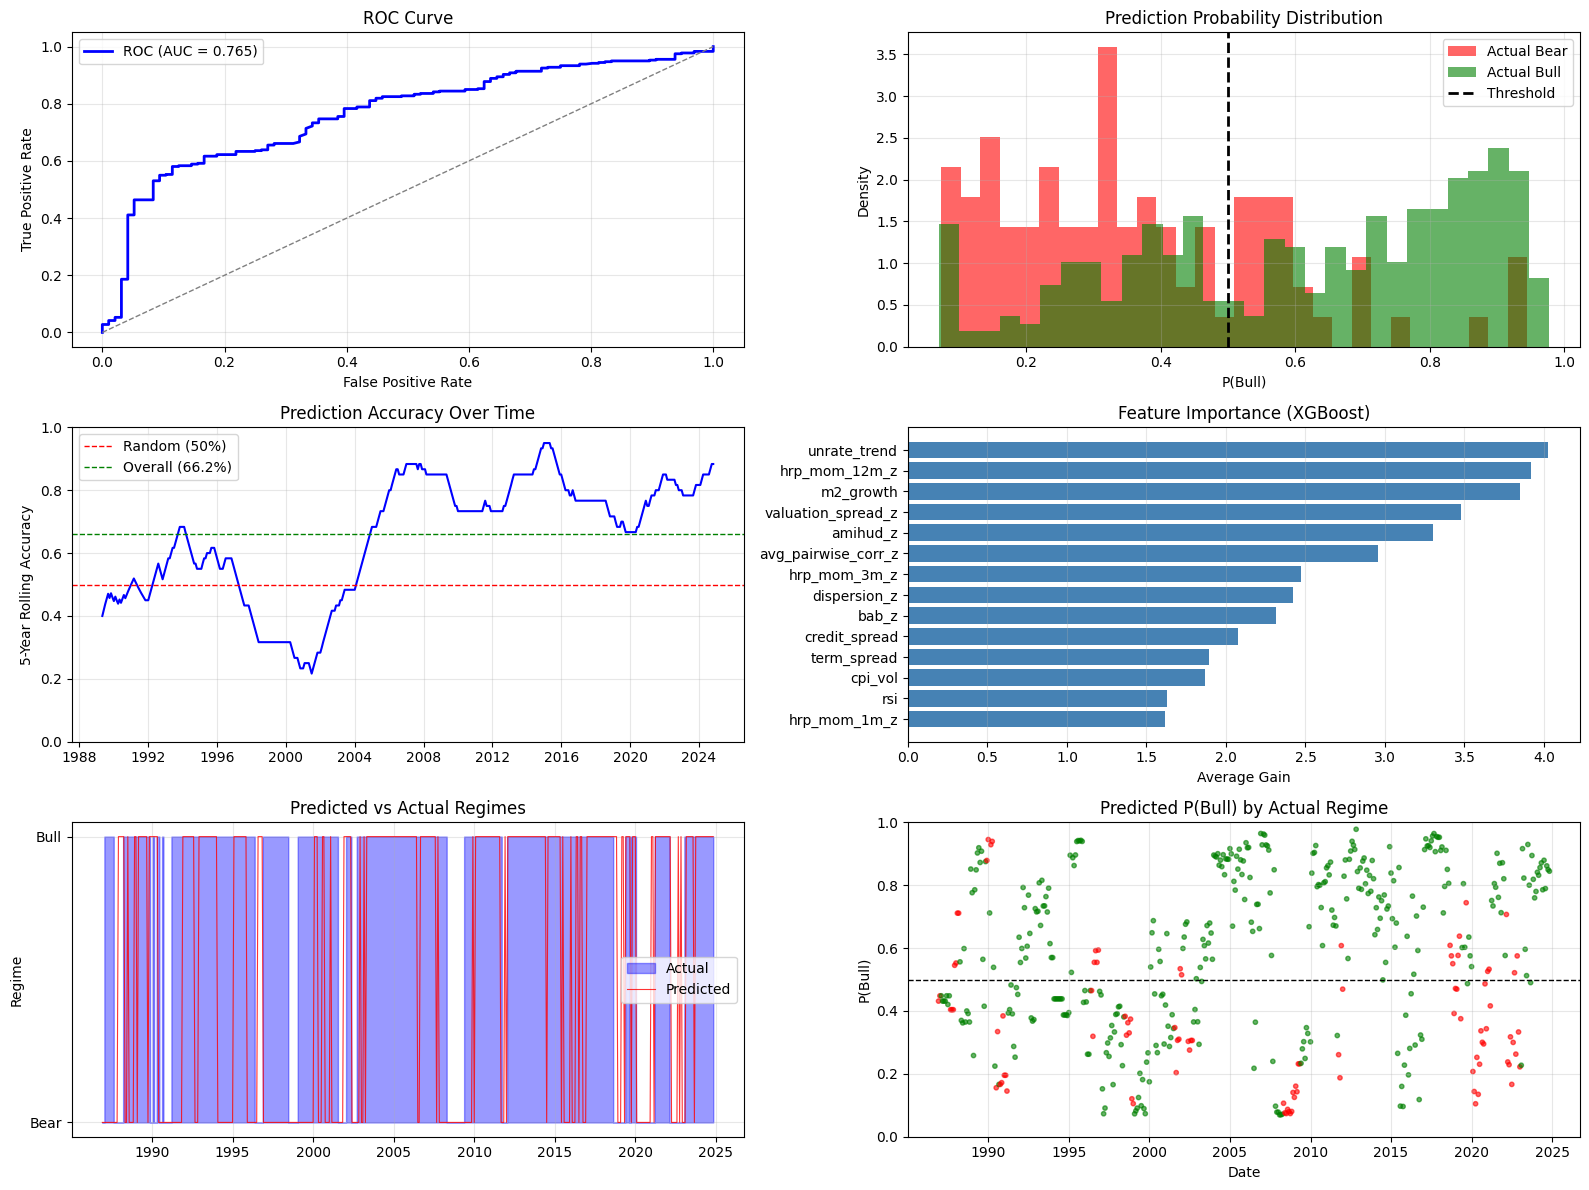


Confusion Matrix:
                    Predicted Bear  Predicted Bull
Actual Bear                   70                26
Actual Bull                  128               232

Top 5 Features (Avg Gain):
  unrate_trend: 4.03
  hrp_mom_12m_z: 3.92
  m2_growth: 3.85
  valuation_spread_z: 3.48
  amihud_z: 3.30


In [77]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 4 (Continued): XGBoost VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("PHASE 4: XGBoost ANALYSIS VISUALIZATION")
print("="*70)

fig = hrp_viz.plot_xgb_analysis(
    wf_df, 
    feature_importances=feature_importances,
    save_path=os.path.join(super_agent_dir, 'phase4_xgb_analysis.png')
)
plt.show()

# Print confusion matrix and top features
hrp_ml.print_xgb_summary(metrics, feature_importances, top_n=5)

In [78]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 5: HRP INTEGRATION (Execution Logic) - GROSS RETURNS
# ═══════════════════════════════════════════════════════════════════════════════

importlib.reload(hrp_strategy)
importlib.reload(hrp_ml)

print("="*70)
print("PHASE 5: HRP INTEGRATION (GROSS RETURNS)")
print("="*70)
print("Two-Fund Separation: w × HRP + (1-w) × T-Bill")
print("Asymmetric Financing: Earn r_f when L<1, Pay r_f+spread when L>1")
print("NOTE: Transaction costs applied in Phase 6")

# Configuration from config.yaml
BEAR_ALLOCATION = strategy_config.get('bear_allocation', 0.5)
FINANCING_SPREAD_BPS = strategy_config.get('financing_spread_bps', 50)
print(f"\nConfig: bear_allocation={BEAR_ALLOCATION}, financing_spread={FINANCING_SPREAD_BPS}bps")

# Compute GROSS strategy returns (includes financing cost, no tx costs yet)
# - stock_returns: enables drift-adjusted turnover calculation
# - financing_spread_bps: asymmetric borrowing cost when leveraged
strategy_results = hrp_strategy.compute_strategy_returns(
    strategy_returns, wf_df, hrp_weights,
    bear_allocation=BEAR_ALLOCATION,
    rf_rate=rf_monthly_aligned,
    stock_returns=returns_all,  # For drift-adjusted turnover
    financing_spread_bps=FINANCING_SPREAD_BPS  # Borrowing spread (IBKR Pro: 50bps)
)

print(f"Strategy results: {len(strategy_results)} months")

# Define strategies (GROSS returns)
strategies = {
    'Buy & Hold HRP': 'hrp_return',
    'P(Bull) Scaled': 'regime_prob_scaled_return'
}

# Performance with bootstrap CI (GROSS)
print("\n[GROSS RETURNS - Before Transaction Costs]")
performance_ci = hrp_ml.print_performance_with_ci(strategy_results, strategies, rf_monthly_aligned)

# Allocation statistics
scale_factor = strategy_results['prob_scale_factor'].iloc[0]
print(f"\nP(Bull) Scaled Allocation:")
print(f"  Scale Factor: {scale_factor:.3f}x (1 / mean P(Bull))")
print(f"  Mean Allocation: {strategy_results['allocation_prob_scaled'].mean():.1%}")
print(f"  Range: [{strategy_results['allocation_prob_scaled'].min():.1%}, {strategy_results['allocation_prob_scaled'].max():.1%}]")
print(f"  % Time Leveraged (w>1): {(strategy_results['allocation_prob_scaled'] > 1).mean():.1%}")

# Prediction quality
pred_quality = hrp_strategy.compute_prediction_quality(strategy_results)
print(f"\nBear Detection Rate: {pred_quality['bear_detection_rate']:.1%}")
print(f"False Bear Rate: {pred_quality['false_bear_rate']:.1%}")

print(f"\n✓ Phase 5 Complete (GROSS returns with financing cost)")

2026-01-06 13:58:26,147 - HRP_Agent - INFO - [!] XGBoost GPU not available (fallback to CPU detected)
PHASE 5: HRP INTEGRATION (GROSS RETURNS)
Two-Fund Separation: w × HRP + (1-w) × T-Bill
Asymmetric Financing: Earn r_f when L<1, Pay r_f+spread when L>1
NOTE: Transaction costs applied in Phase 6

Config: bear_allocation=0.5, financing_spread=50bps
2026-01-06 13:58:30,030 - HRP_Agent - INFO - Computing drift-adjusted turnover (accounts for price drift during holding period)


2026-01-06 13:58:36,986 - HRP_Agent - INFO - Strategy GROSS returns computed for 456 months
2026-01-06 13:58:36,992 - HRP_Agent - INFO - Prob-Weighted scale factor: 1.776x (mean P(Bull)=0.563)
2026-01-06 13:58:36,996 - HRP_Agent - INFO - Mean Rf rate: 2.95% annualized (over strategy period)
2026-01-06 13:58:37,003 - HRP_Agent - INFO - Financing spread: 50 bps (applied in NET only)
2026-01-06 13:58:37,010 - HRP_Agent - INFO - Levered months: 236/456 (51.8%), avg leverage when levered: 1.40x
Strategy results: 456 months

[GROSS RETURNS - Before Transaction Costs]

PERFORMANCE COMPARISON (95% CI) - Excess Return Sharpe
Risk-Free Rate: Mean = 3.39% annualized

Strategy                       Ann Return             Sharpe             Max DD
--------------------------------------------------------------------------------
Buy & Hold HRP         10.7% [6.0%, 15.3%]  0.55 [0.24, 0.90]             -45.7%
P(Bull) Scaled         15.2% [11.2%, 19.1%]  0.93 [0.63, 1.24]             -21.0%

P(Bull) Sc

2026-01-06 19:34:41,059 - HRP_Agent - INFO - [!] XGBoost GPU not available (fallback to CPU detected)
PHASE 5: EQUITY CURVES (Linear + Log Scale)

PERFORMANCE SUMMARY (Annualized) - Excess Return Sharpe
Date Range: 1986-11 to 2024-10 (456 months)
Risk-Free Rate: Mean = 3.39% annualized

Strategy               Return      Vol   Sharpe        DD1        DD2        DD3        DD4        DD5
---------------------------------------------------------------------------------------------------------
Buy & Hold HRP         10.7%   14.3%     0.55     -45.7%     -29.3%     -25.1%     -22.5%     -22.3%
P(Bull) Scaled         15.2%   12.4%     0.93     -21.0%     -17.8%     -15.8%     -14.6%     -13.5%
CRSP VW Index          11.5%   15.5%     0.59     -39.6%     -31.4%     -26.3%     -17.8%     -16.6%
---------------------------------------------------------------------------------------------------------

TOP 5 DRAWDOWN PERIODS (by magnitude)

Buy & Hold HRP:
  1.  -45.7%  (2007-05 to 2009-01)
  2

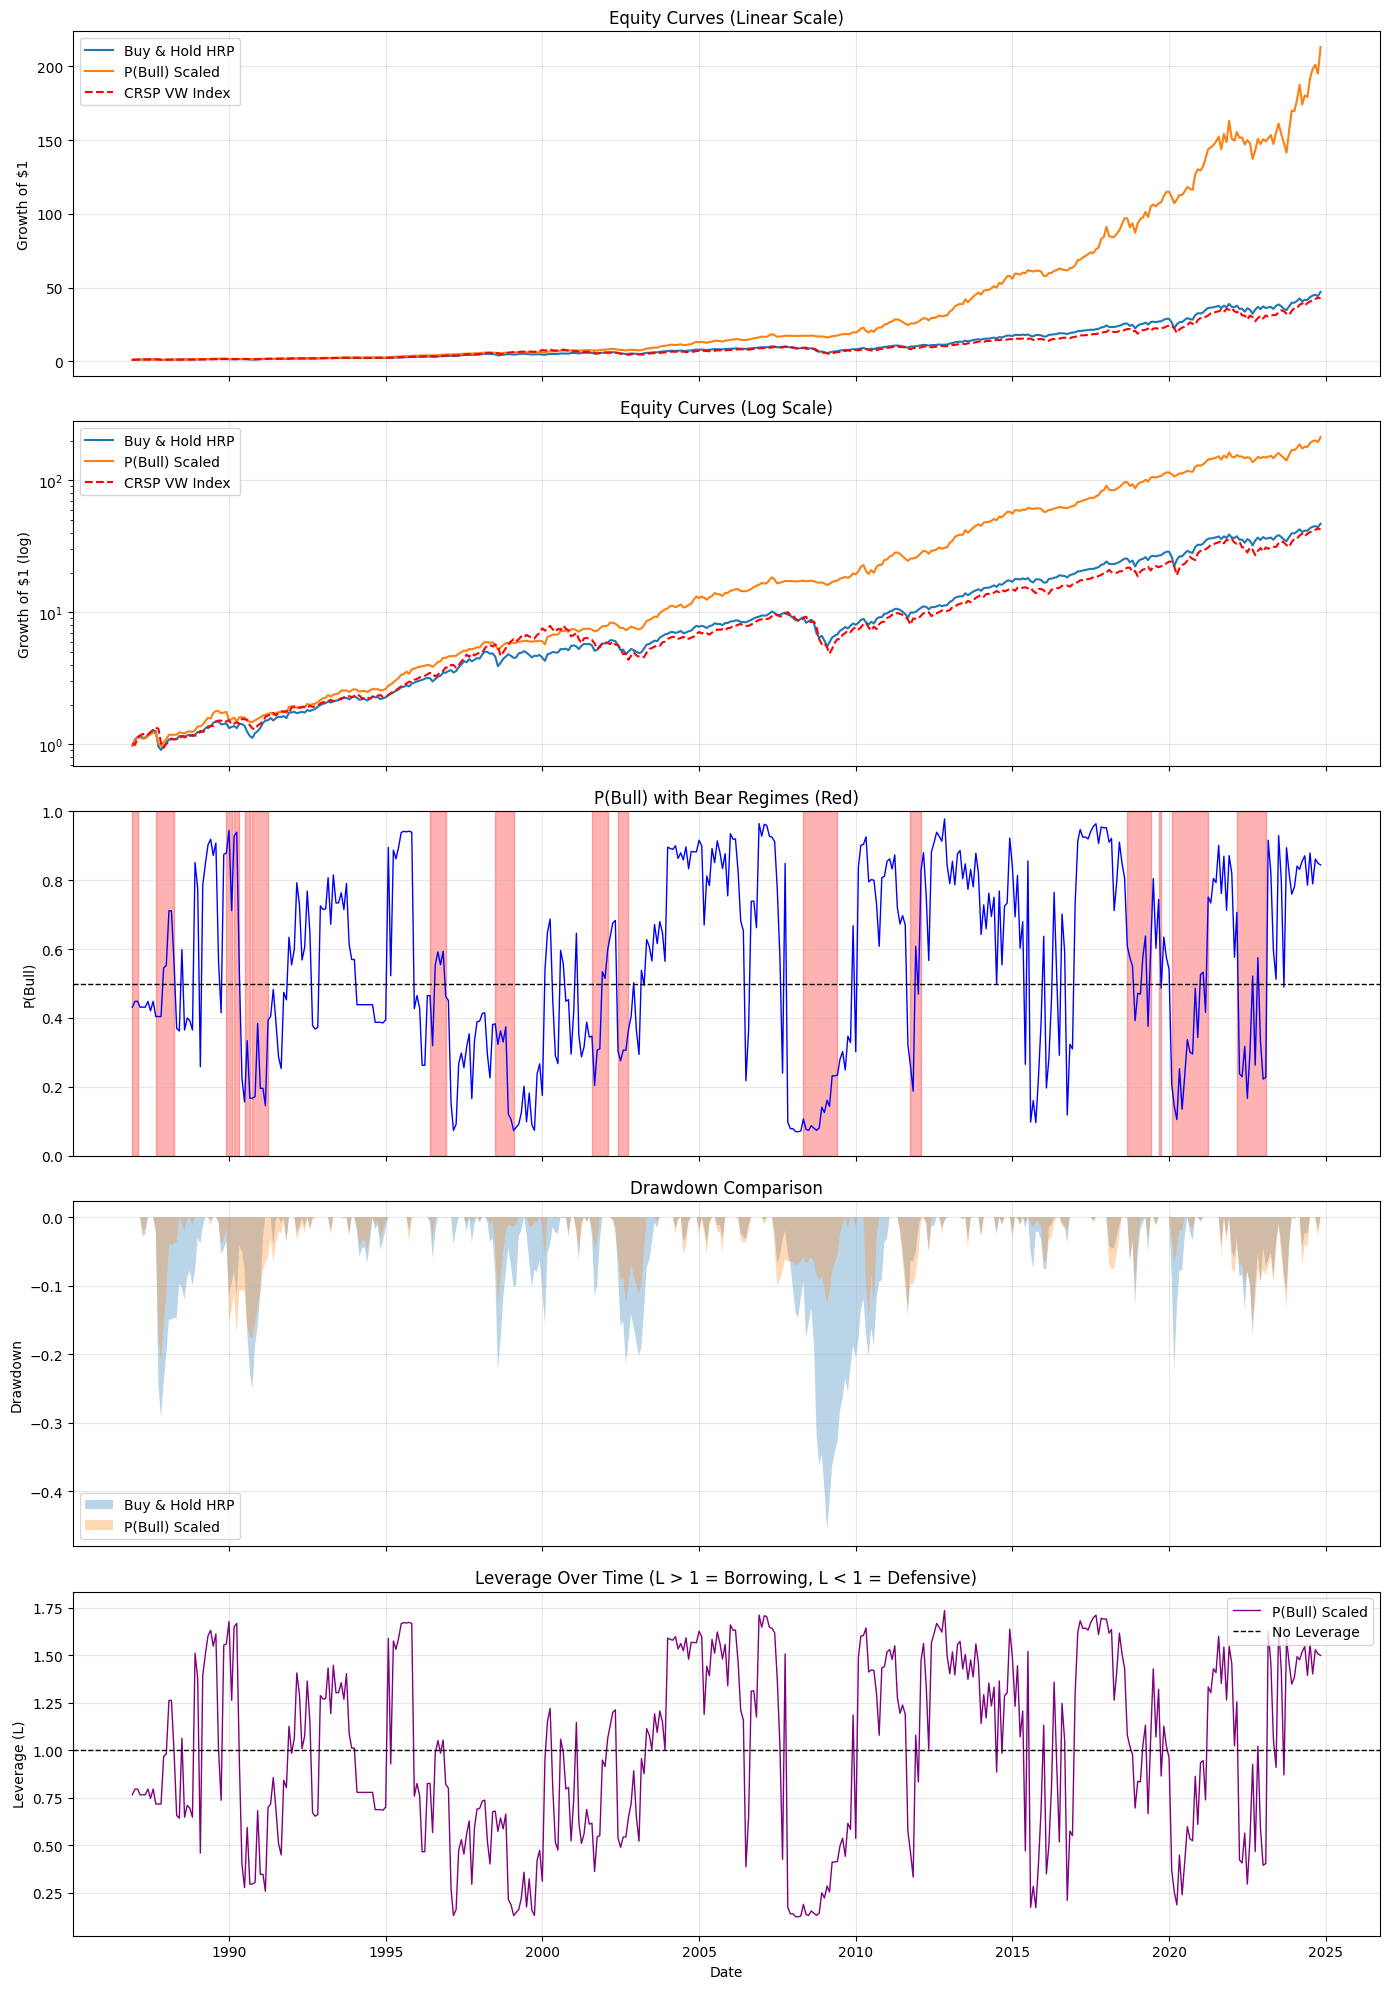

✓ Equity curves plotted (both linear and log scale)


In [83]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 5 (Continued): EQUITY CURVES VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

# Reload modules
importlib.reload(hrp_viz)
importlib.reload(hrp_ml)

print("="*70)
print("PHASE 5: EQUITY CURVES (Linear + Log Scale)")
print("="*70)

# Print performance summary with top 3 drawdowns (HRP, P(Bull) Scaled, CRSP VW)
metrics_summary = hrp_ml.print_performance_summary(
    strategy_results, strategies, market_returns, rf_monthly_aligned
)

# Plot equity curves
fig = hrp_viz.plot_strategy_equity_curves(
    strategy_results, 
    strategies,
    market_returns=market_returns,
    save_path=os.path.join(super_agent_dir, 'phase5_hrp_integration.png')
)
plt.show()

print("✓ Equity curves plotted (both linear and log scale)")

2026-01-06 13:59:11,496 - HRP_Agent - INFO - [!] XGBoost GPU not available (fallback to CPU detected)
PHASE 6: TRANSACTION COST ANALYSIS
Transaction Cost: 10 bps
Inner Cost: Drift-adjusted turnover (accounts for price drift)
Outer Cost: 2× allocation change (both HRP and T-Bill sides)
2026-01-06 13:59:11,551 - HRP_Agent - INFO - Transaction costs applied (10 bps)
2026-01-06 13:59:11,558 - HRP_Agent - INFO -   Inner cost (HRP turnover ? L): 0.46% annualized (scaled)
2026-01-06 13:59:11,561 - HRP_Agent - INFO -   Outer cost (2 ? |?L| ? bps): 0.47% annualized
2026-01-06 13:59:11,564 - HRP_Agent - INFO -   Financing cost (spread when L>1): 0.10% annualized

TRANSACTION COST ANALYSIS (10 bps)

📊 INNER COST (HRP Rebalancing - Drift-Adjusted Turnover):
   Formula: inner_cost = L × turnover × 10bps
   Where:   turnover = Σ|w_target,t - w_drifted,t|
   Mean Monthly Turnover: 38.9%
   Base Annualized Inner Cost (L=1): 0.47%

📊 OUTER COST (Leverage Overlay - Both Sides):
   Formula: outer_cost = 


Strategy                       Ann Return             Sharpe             Max DD
--------------------------------------------------------------------------------
Buy & Hold HRP         10.1% [5.5%, 14.8%]  0.51 [0.21, 0.86]             -46.2%
P(Bull) Scaled         14.0% [10.1%, 17.9%]  0.85 [0.56, 1.15]             -21.1%

GROSS vs NET PERFORMANCE COMPARISON

Strategy               Gross Sharpe     Net Sharpe    Sharpe Drag
-----------------------------------------------------------------
Buy & Hold HRP                 0.55           0.51           0.03
P(Bull) Scaled                 0.93           0.85           0.08

EQUITY CURVES: GROSS vs NET
2026-01-06 13:59:39,953 - HRP_Agent - INFO - Saved GROSS vs NET equity plot to c:\Users\lucas\OneDrive\Bureau\HRP\Super_Agent_Output\phase6_gross_vs_net_equity.png

Terminal Wealth ($1 invested):
  HRP GROSS:            $46.98
  HRP NET:              $39.39 (drag: $7.59)
  P(Bull) Scaled GROSS: $213.10
  P(Bull) Scaled NET:   $144.23 (drag: $

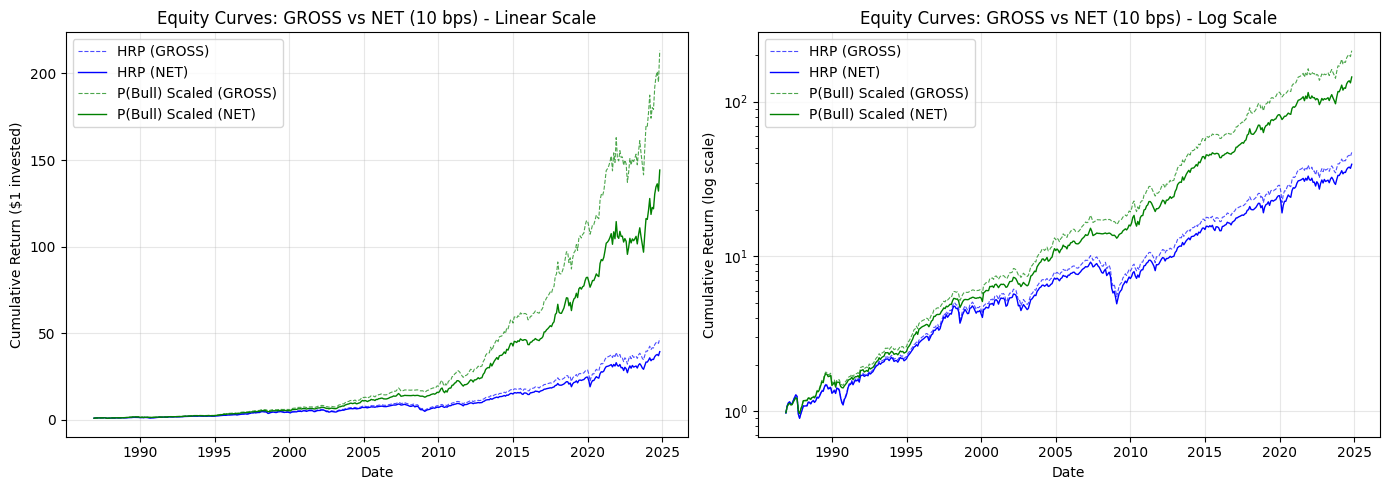


✓ Phase 6 Complete


In [80]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 6: TRANSACTION COST ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════
# Inner Cost (HRP Rebalancing): Uses DRIFT-ADJUSTED turnover
#   Turnover_t = Σ|w_target,t - w_drifted,t| where w_drifted = w_prev × (1+r_i)/(1+r_p)
# Outer Cost (Leverage Overlay): Charges BOTH sides (HRP ↔ T-Bill)
#   outer_t = 2 × |L_t - L_{t-1}| × C_bps

importlib.reload(hrp_strategy)
importlib.reload(hrp_ml)

print("="*70)
print("PHASE 6: TRANSACTION COST ANALYSIS")
print("="*70)

# Load tx_cost_bps from config
TX_COST_BPS = strategy_config.get('tx_cost_bps', 10)
print(f"Transaction Cost: {TX_COST_BPS} bps")
print(f"Inner Cost: Drift-adjusted turnover (accounts for price drift)")
print(f"Outer Cost: 2× allocation change (both HRP and T-Bill sides)")

# Apply transaction costs (inner + outer)
strategy_results_net = hrp_strategy.compute_net_returns(strategy_results, tx_cost_bps=TX_COST_BPS)

# Print detailed cost breakdown
hrp_strategy.print_tx_cost_summary(strategy_results_net, tx_cost_bps=TX_COST_BPS)

# Define NET strategies
strategies_net = {
    'Buy & Hold HRP': 'hrp_return_net',
    'P(Bull) Scaled': 'regime_prob_scaled_return_net'
}

# Performance with bootstrap CI (NET)
print("\n[NET RETURNS - After Transaction Costs]")
performance_ci_net = hrp_ml.print_performance_with_ci(strategy_results_net, strategies_net, rf_monthly_aligned)

# Compare GROSS vs NET performance
print("\n" + "="*70)
print("GROSS vs NET PERFORMANCE COMPARISON")
print("="*70)
print(f"\n{'Strategy':<20} {'Gross Sharpe':>14} {'Net Sharpe':>14} {'Sharpe Drag':>14}")
print("-"*65)

gross_sharpe_hrp = performance_ci['Buy & Hold HRP']['Sharpe']
net_sharpe_hrp = performance_ci_net['Buy & Hold HRP']['Sharpe']
print(f"{'Buy & Hold HRP':<20} {gross_sharpe_hrp:>14.2f} {net_sharpe_hrp:>14.2f} {gross_sharpe_hrp - net_sharpe_hrp:>14.2f}")

gross_sharpe_scaled = performance_ci['P(Bull) Scaled']['Sharpe']
net_sharpe_scaled = performance_ci_net['P(Bull) Scaled']['Sharpe']
print(f"{'P(Bull) Scaled':<20} {gross_sharpe_scaled:>14.2f} {net_sharpe_scaled:>14.2f} {gross_sharpe_scaled - net_sharpe_scaled:>14.2f}")

# ═══════════════════════════════════════════════════════════════════════════════
# EQUITY CURVES: GROSS vs NET (Linear + Log Scale)
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "="*70)
print("EQUITY CURVES: GROSS vs NET")
print("="*70)

fig = hrp_viz.plot_gross_vs_net_equity(
    strategy_results, strategy_results_net, 
    tx_cost_bps=TX_COST_BPS,
    save_path=os.path.join(super_agent_dir, 'phase6_gross_vs_net_equity.png')
)
plt.show()

print(f"\n✓ Phase 6 Complete")

In [81]:
# ═══════════════════════════════════════════════════════════════════════════════
# FINAL OUTPUT: SAVE ALL RESULTS
# ═══════════════════════════════════════════════════════════════════════════════
import json

print("="*70)
print("FINAL OUTPUT: SAVING RESULTS")
print("="*70)

# Save strategy results (NET - after transaction costs)
strategy_results_net.to_csv(os.path.join(super_agent_dir, 'regime_strategy_results.csv'))
print("✓ Strategy results (NET) saved")

# Save HMM regimes
df_regimes.to_csv(os.path.join(super_agent_dir, 'hmm_regimes_v2.csv'))
print("✓ HMM regimes saved")

# Save performance summary (NET)
perf_df = pd.DataFrame([{
    'Strategy': name,
    'Ann Return': m['Ann Return'],
    'Ann Vol': m['Ann Vol'],
    'Sharpe': m['Sharpe'],
    'Max DD': m['Max DD'],
    'Win Rate': m['Win Rate']
} for name, m in performance_ci_net.items()])
perf_df.to_csv(os.path.join(super_agent_dir, 'regime_performance_summary.csv'), index=False)
print("✓ Performance summary (NET) saved")

# Save model configuration
model_config = {
    'hmm': {'n_components': 2, 'min_train': HMM_MIN_TRAIN, 'refit_freq': HMM_REFIT_FREQ},
    'features': FEATURE_COLS,
    'tx_cost_bps': TX_COST_BPS,
    'prediction_metrics': {k: float(v) if isinstance(v, (np.floating, float)) else v 
                          for k, v in metrics.items() if k != 'confusion_matrix'},
    'date_range': {'start': str(strategy_results_net.index.min().date()), 
                   'end': str(strategy_results_net.index.max().date())}
}

with open(os.path.join(super_agent_dir, 'regime_model_config.json'), 'w') as f:
    json.dump(model_config, f, indent=2, default=str)
print("✓ Model configuration saved")

# Final summary
print("\n" + "="*70)
print("PIPELINE COMPLETE")
print("="*70)
print(f"""
Summary:
  Phase 1: HMM data prepared ({len(df_hmm)} observations)
  Phase 2: {len(df_regimes)} months labeled (Bear/Bull)
  Phase 3: {len(FEATURE_COLS)} features selected
  Phase 4: {len(wf_df)} out-of-sample predictions (Acc={metrics['accuracy']:.1%}, AUC={metrics['roc_auc']:.3f})
  Phase 5: {len(strategies)} strategy variants (GROSS returns)
  Phase 6: Transaction costs applied ({TX_COST_BPS} bps)

Best Strategy (NET): {perf_df.loc[perf_df['Sharpe'].idxmax(), 'Strategy']} (Sharpe = {perf_df['Sharpe'].max():.2f})
""")

print(perf_df.to_string(index=False))

FINAL OUTPUT: SAVING RESULTS
✓ Strategy results (NET) saved
✓ HMM regimes saved
✓ Performance summary (NET) saved
✓ Model configuration saved

PIPELINE COMPLETE

Summary:
  Phase 1: HMM data prepared (688 observations)
  Phase 2: 628 months labeled (Bear/Bull)
  Phase 3: 14 features selected
  Phase 4: 456 out-of-sample predictions (Acc=66.2%, AUC=0.765)
  Phase 5: 2 strategy variants (GROSS returns)
  Phase 6: Transaction costs applied (10 bps)

Best Strategy (NET): P(Bull) Scaled (Sharpe = 0.85)

      Strategy  Ann Return  Ann Vol   Sharpe    Max DD  Win Rate
Buy & Hold HRP    0.101499 0.143032 0.514657 -0.461580  0.644737
P(Bull) Scaled    0.139769 0.124006 0.849353 -0.211137  0.646930
